<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/QUANT026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fake-useragent

In [2]:
TICKER = '^GSPC'  # 股票代码，这里是标普500指数
STOCK = 'S&P 500'  # 股票名称，这里是标普500

# 日期范围 (YYYY-MM-DD) 和频率
START_DATE = '2000-01-01'  # 开始日期：2000年1月1日
END_DATE = '2023-12-31'  # 结束日期：2023年12月31日
FREQ = '1d'  # 频率：1天，表示每日数据

FILE_NAME = 'sp500_daily'  # 自定义文件名：sp500_daily

In [3]:
# 训练集、验证集、测试集划分
TRAIN_END_DATE = '2021-01-01'  # 训练集结束日期：2021年1月1日
VAL_END_DATE = '2022-07-01'  # 验证集结束日期：2022年7月1日


In [4]:
SEQ_LENGTH = 100
SEQ_LENGTH_XLSTM = 150
RANDOM_STATE = 0
FULL_TRAINING = False

In [5]:
import datetime  # 导入日期时间模块
import yfinance as yf  # 导入 yfinance 库，用于从 Yahoo Finance 获取数据
import requests  # 导入 requests 库，用于发送 HTTP 请求
import pandas as pd  # 导入 pandas 库，用于处理数据，特别是 DataFrame
import time  # 导入 time 模块，用于处理时间相关操作，例如暂停
import os  # 导入 os 模块，用于与操作系统交互，例如访问环境变量
import urllib.parse  # 导入 urllib.parse 模块，用于解析 URL
from fake_useragent import UserAgent # 导入 fake_useragent，生成User-Agent

# 实用函数：验证日期格式 (YYYY-MM-DD)
def _check_date_format(date):
    """
    检查给定的日期字符串是否符合 YYYY-MM-DD 格式。

    参数:
        date (str): 要检查的日期字符串。

    返回:
        datetime.datetime: 如果日期格式正确，则返回 datetime 对象；否则返回 None。
    """
    try:
        return datetime.datetime.strptime(date, "%Y-%m-%d")  # 尝试将日期字符串解析为 datetime 对象
    except ValueError:
        return None  # 如果日期格式不正确，则捕获 ValueError 异常并返回 None

# 主要函数：从 Yahoo Finance 或 Tiingo 下载数据
def download_data(ticker, start_date=None, end_date=None, freq='1d'):
    """
    从 Yahoo Finance 或 Tiingo 下载股票数据。

    参数:
        ticker (str): 股票代码（例如 'AAPL'）。
        start_date (str, 可选): 下载数据的开始日期 (YYYY-MM-DD)。如果为 None，则从最早可用日期开始下载。
        end_date (str, 可选): 下载数据的结束日期 (YYYY-MM-DD)。如果为 None，则下载到当前日期。
        freq (str, 可选): 数据频率。'1d' 表示日数据，'1h' 表示小时数据。默认为 '1d'。

    返回:
        pandas.DataFrame: 包含股票数据的 DataFrame。如果下载失败，可能返回空的 DataFrame。
    """
    if freq == '1h':
        try:
            # 尝试从 Tiingo API 下载数据（超过 730 天）
            return _download_tiingo_data(ticker, start_date, end_date)
        except DataDownloadError:
            pass
            # 继续使用 Yahoo Finance 数据下载（少于 730 天）

    # 使用 Yahoo Finance 获取数据
    data = yf.Ticker(ticker)  # 创建 yf.Ticker 对象，用于获取股票信息
    start_date_dt = _check_date_format(start_date)  # 检查并转换开始日期
    end_date_dt = _check_date_format(end_date)  # 检查并转换结束日期

    try:
        if freq == '1h':
            if not start_date_dt or (start_date_dt and start_date_dt < end_date_dt - datetime.timedelta(days=730)):
                return data.history(period='2y', interval=freq)  # API 限制： intraday 数据
            return data.history(start=start_date_dt, end=end_date_dt, interval=freq)

        if not start_date_dt:  # 从最早的日期开始获取数据
            return data.history(end=end_date_dt, period='max', interval=freq)
        else:
            return data.history(start=start_date_dt, end=end_date_dt, interval=freq)
    except (ValueError, TypeError, AttributeError):
        return data.history(period='max', interval=freq)  # 发生错误时，尝试下载最大时间段的数据

# 实用函数：从 Tiingo API 获取盘中数据
def _fetch_intraday_data(ticker, start_date, end_date, api_key):
    """
    从 Tiingo API 获取盘中数据（小时级别）。

    参数:
        ticker (str): 股票代码。
        start_date (str): 开始日期 (YYYY-MM-DD)。
        end_date (str): 结束日期 (YYYY-MM-DD)。
        api_key (str): Tiingo API 密钥。

    返回:
        pandas.DataFrame: 包含盘中数据的 DataFrame，如果请求失败则返回空的 DataFrame。
                        DataFrame 的索引是日期时间 ('date')，列包括 'Open', 'High', 'Low', 'Close', 'Volume' 等。
    """
    url = f'https://api.tiingo.com/iex/{ticker}/prices?startDate={start_date}&endDate={end_date}&resampleFreq=1hour&token={api_key}'  # 构造 API 请求 URL
    response = requests.get(url)  # 发送 GET 请求
    if response.status_code == 200:  # 检查响应状态码
        data = response.json()  # 解析 JSON 响应
        df = pd.DataFrame(data)  # 将数据转换为 DataFrame (DataFrame 维度: (时间点数量, 特征数量))
        if not df.empty:
            df['date'] = pd.to_datetime(df['date'])  # 将 'date' 列转换为 datetime 类型
            df.set_index('date', inplace=True)  # 将 'date' 列设置为 DataFrame 的索引
            df.index.name = 'Date'  # 设置索引的名称为 'Date'
            df.columns = [col.capitalize() for col in df.columns]  # 将列名首字母大写
        return df  # 返回 DataFrame
    else:
        print(f"Failed to fetch data for {start_date} to {end_date}")
        return pd.DataFrame()  # 返回空的 DataFrame

# 自定义异常：处理数据下载错误
class DataDownloadError(Exception):
    """当由于缺少 API 密钥或 API 限制导致数据下载失败时引发的异常。"""
    pass

# 函数：处理 Tiingo 数据下载，带分页功能
def _download_tiingo_data(ticker, start_date=None, end_date=None):
    """
    从 Tiingo 下载股票数据，处理 API 分页限制。

    参数:
        ticker (str): 股票代码。
        start_date (str, 可选): 开始日期 (YYYY-MM-DD)。如果为 None，则下载 730 天前的数据。
        end_date (str, 可选): 结束日期 (YYYY-MM-DD)。如果为 None，则下载到当前日期。

    返回:
        pandas.DataFrame: 包含股票数据的 DataFrame。
    """
    TIINGO_API_KEY = "006d2fea3e93be61f3dff54c0ce2a44d3b6e5e2d"  #  Tiingo API 密钥

    # 检查是否设置了 API 密钥
    if not TIINGO_API_KEY:
        raise DataDownloadError("TIINGO_API_KEY is missing. Please set the environment variable.")

    try:
        end_date_dt = end_date.strftime("%Y-%m-%d")  # 将结束日期转换为字符串
    except (ValueError, TypeError, AttributeError):
        end_date_dt = datetime.datetime.now()  # 如果结束日期无效，则使用当前日期

    try:
        start_date_dt = datetime.datetime.strptime(start_date, "%Y-%m-%d")  # 将开始日期转换为 datetime 对象
    except (ValueError, TypeError):
        start_date_dt = end_date_dt - datetime.timedelta(days=730)  # 如果开始日期无效，则设置为结束日期前 730 天

    # 用于存储合并后数据的 DataFrame
    all_data = pd.DataFrame()  # 初始化一个空的 DataFrame (DataFrame 维度: (0, 特征数量))

    # 由于 API 限制，分块获取数据
    chunk_end_date = end_date_dt
    while chunk_end_date > start_date_dt:
        chunk_start_date = chunk_end_date - datetime.timedelta(days=730)
        if chunk_start_date < start_date_dt:
            chunk_start_date = start_date_dt

        # 将日期转换为 API 所需的字符串格式
        chunk_start_date_str = chunk_start_date.strftime('%Y-%m-%d')
        chunk_end_date_str = chunk_end_date.strftime('%Y-%m-%d')

        try:
            # 获取数据
            df = _fetch_intraday_data(ticker, chunk_start_date_str, chunk_end_date_str, TIINGO_API_KEY)  # (DataFrame 维度: (时间点数量, 特征数量))
            all_data = pd.concat([df, all_data])  # 将获取到的数据块合并到 all_data 中 (DataFrame 维度: (累积时间点数量, 特征数量))
        except Exception as e:
            raise DataDownloadError(f"Failed to download data from TIINGO for {ticker}. Error: {str(e)}")

        # 更新下一个数据块的结束日期
        chunk_end_date = chunk_start_date - datetime.timedelta(days=1)

        # 遵守 API 速率限制
        time.sleep(1)

    # 按时间戳降序排列合并后的数据
    all_data.sort_index(ascending=True, inplace=True)  # (DataFrame 维度: (总时间点数量, 特征数量))

    return all_data  # 返回最终的 DataFrame

# 函数：搜索股票代码
def search_ticker(search_term):
    """
    使用 Yahoo Finance API 搜索股票代码。

    参数:
        search_term (str): 要搜索的股票名称或代码。

    返回:
        list: 包含搜索结果的列表。每个结果是一个字典，包含 'symbol' (股票代码) 和 'name' (股票名称)。
              如果搜索失败，则返回空列表。
    """
    encoded_search_term = urllib.parse.quote(search_term)  # 对搜索词进行 URL 编码

    # 构造带有搜索词的 URL
    search_url = f'https://query2.finance.yahoo.com/v1/finance/search?q={encoded_search_term}&lang=en-US&region=US&quotesCount=8&quotesQueryId=tss_match_phrase_query&multiQuoteQueryId=multi_quote_single_token_query&enableCb=true&enableNavLinks=true&enableCulturalAssets=true&enableNews=false&enableResearchReports=false&researchReportsCount=2&newsCount=0'

    # 获取最新 Chrome 的 User-Agent
    ua = UserAgent()
    HEADERS = {
        'User-Agent': ua.chrome
    }

    # 执行 GET 请求
    response = requests.get(search_url, headers=HEADERS)  # 发送带有 User-Agent 的 GET 请求

    # 检查请求是否成功
    if response.status_code == 200:
        # 解析 JSON 响应
        results = response.json()

        search_results = []
        for quote in results.get('quotes', []):  # 遍历搜索结果中的股票信息
            symbol = quote.get('symbol')  # 获取股票代码
            name = quote.get('shortname')  # 获取股票名称

            if symbol and name:
                search_results.append({'symbol': symbol, 'name': name})  # 将股票代码和名称添加到结果列表中

        return search_results  # 返回搜索结果列表
    else:
        print(f"Failed to retrieve data. HTTP Status code: {response.status_code}")
        return []  # 返回空列表


In [6]:
# src/ml/utils/visualisation.py

import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot 模块，用于数据可视化

# -------------------------------------------------------------------------------------------
# 可视化工具，用于绘制图表和数据表示
# -------------------------------------------------------------------------------------------

def plot_data(df, stock, ax=None):
    """
    绘制股票价格数据。

    参数:
        df (pandas.DataFrame): 包含股票价格数据的 DataFrame。
            DataFrame 的索引是日期，列中应包含 'Close' (收盘价)。
            (DataFrame 维度: (时间点数量, 特征数量),  其中一列为 'Close')
        stock (str): 股票名称或代码，用于图表标题。
        ax (matplotlib.axes._subplots.AxesSubplot, 可选):
            可选的 matplotlib Axes 对象，用于在现有图表中绘制。如果为 None，则创建一个新的图表。

    返回:
        None: 此函数不返回任何值，它直接显示或在给定的 Axes 对象上绘制图表。
    """
    if not df.empty:  # 检查 DataFrame 是否为空
        if ax:
            ax.clear()  # 清除现有的 Axes 对象
            ax.plot(df.index, df['Close'], label=stock)  # 绘制收盘价，df.index 是日期 (维度: (时间点数量,))， df['Close'] 是收盘价序列 (维度: (时间点数量,))
            ax.set_title(f'{stock} Price Data')  # 设置图表标题
            ax.set_xlabel('Date')  # 设置 x 轴标签
            ax.set_ylabel('Price')  # 设置 y 轴标签
            ax.legend()  # 显示图例
        else:
            plt.figure(figsize=(10, 7))  # 创建一个新的图表
            plt.plot(df.index, df['Close'], label=stock)  # 绘制收盘价
            plt.title(f'{stock} Price Data')  # 设置图表标题
            plt.xlabel('Date')  # 设置 x 轴标签
            plt.ylabel('Close Price')  # 设置 y 轴标签
            plt.show()  # 显示图表

def plot_data_split(train_dates, train_y, val_dates, val_y, test_dates, test_y, stock):
    """
    绘制股票价格数据的训练集、验证集和测试集划分。

    参数:
        train_dates (array-like): 训练集的日期序列。 (维度: (训练集时间点数量,))
        train_y (array-like): 训练集的收盘价序列。 (维度: (训练集时间点数量,))
        val_dates (array-like): 验证集的日期序列。   (维度: (验证集时间点数量,))
        val_y (array-like): 验证集的收盘价序列。   (维度: (验证集时间点数量,))
        test_dates (array-like): 测试集的日期序列。  (维度: (测试集时间点数量,))
        test_y (array-like): 测试集的收盘价序列。  (维度: (测试集时间点数量,))
        stock (str): 股票名称或代码，用于图表标题。

    返回:
        None: 此函数不返回任何值，它直接显示图表。
    """
    # 绘制数据
    plt.figure(figsize=(10, 7))  # 创建一个新的图表

    plt.plot(train_dates, train_y, label='Train Data', color='blue')  # 绘制训练集
    plt.plot(val_dates, val_y, label='Validation Data', color='green')  # 绘制验证集
    plt.plot(test_dates, test_y, label='Test Data', color='red')  # 绘制测试集

    plt.title(f'{stock} Stock Price - Train, Validation, Test Sets')  # 设置图表标题
    plt.xlabel('Date')  # 设置 x 轴标签
    plt.ylabel('Close Price')  # 设置 y 轴标签
    plt.legend()  # 显示图例
    plt.show()  # 显示图表


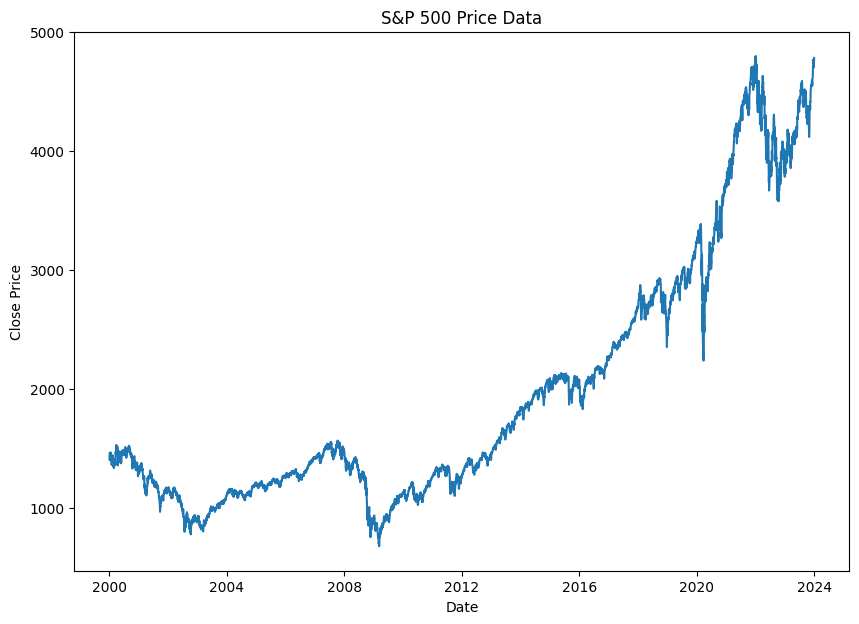

In [7]:
# 下载数据
df = download_data(ticker=TICKER, start_date=START_DATE, end_date=END_DATE, freq=FREQ)  # 调用 download_data 函数下载数据，并将结果存储在 DataFrame `df` 中
# DataFrame df 的维度取决于下载的数据，通常为 (时间点数量, 特征数量)，例如 (交易日数量, 股票信息数量)

# 绘制原始数据
plot_data(df, STOCK)  # 调用 plot_data 函数绘制下载的原始数据
# df:  (DataFrame 维度: (时间点数量, 特征数量))
# STOCK: (股票名称，字符串)


In [8]:
!pip install PyWavelets

In [9]:
# src/ml/data/preprocessing.py

import pywt  # 导入 pywt 库，用于小波变换
import numpy as np  # 导入 numpy 库，用于数值计算
import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot 库，用于绘图

# -------------------------------------------------------------------------------------------
# 小波去噪
#
# 参考文献: https://doi.org/10.1002/for.3071
# (小波去噪的思想和一些参数取自这篇论文)
# -------------------------------------------------------------------------------------------

# 用于填充数据的函数
def pad_data(data, pad_width, mode='edge'):
    """
    填充数据，以减少小波变换边缘效应。

    参数:
        data (array-like): 要填充的数据，例如一维时间序列。 (维度: (数据点数量,))
        pad_width (int 或 tuple): 填充宽度。如果为 int，则两侧填充相同的宽度。
                                  如果为 tuple，则指定 (before, after) 的填充宽度。
        mode (str, 可选): 填充模式。默认为 'edge'，表示用边缘值填充。

    返回:
        numpy.ndarray: 填充后的数据。 (维度: (数据点数量 + 2 * pad_width,))
    """
    return np.pad(data, pad_width, mode=mode)  # 使用 numpy.pad 函数进行填充

# 小波去噪函数，带有小波类型和分解级别的参数
def wavelet_denoising(data, wavelet='db4', level=1):
    """
    使用小波变换对数据进行去噪。

    参数:
        data (array-like): 要去噪的数据，例如一维时间序列。 (维度: (数据点数量,))
        wavelet (str, 可选): 小波基函数类型。默认为 'db4' (Daubechies 4)。
        level (int, 可选): 小波分解级别。默认为 1。

    返回:
        numpy.ndarray: 去噪后的数据。 (维度: (数据点数量,))
    """
    # 使用宽度为 100 进行填充
    padded_data = pad_data(data, pad_width=100, mode='edge')  # (维度: (数据点数量 + 200,))
    # 使用小波变换分解信号
    coeff = pywt.wavedec(padded_data, wavelet, mode="per", level=level)  # `coeff` 是一个列表，包含分解系数
    #  - coeff[0]: 近似系数 (低频)
    #  - coeff[1] 到 coeff[level]: 细节系数 (高频)
    #  每个 coeff[i] 的长度取决于分解级别和数据长度

    # 估计噪声水平
    sigma = (1 / 0.6745) * np.median(np.abs(coeff[-level] - np.median(coeff[-level])))  # 使用中值绝对偏差估计噪声标准差
    # 计算通用阈值
    uthresh = sigma * np.sqrt(2 * np.log(len(padded_data)))  # 使用估计的噪声标准差计算通用阈值
    # 将软阈值应用于细节系数
    coeff[1:] = [pywt.threshold(i, value=uthresh, mode='soft') for i in coeff[1:]]  # 对除近似系数外的所有系数进行软阈值处理
    # 将高频系数设置为零
    coeff[-level] = np.zeros_like(coeff[-level])  # 将最高频的细节系数置零，进一步去噪
    # 重构去噪后的信号
    denoised_data = pywt.waverec(coeff, wavelet, mode='per')  # 使用修改后的系数重构信号 (维度: (数据点数量 + 200,))
    # 移除填充
    denoised_data = denoised_data[100:-100]  # 移除之前添加的填充 (维度: (数据点数量,))

    # 处理边缘效应
    if len(denoised_data) > len(data):
        denoised_data = denoised_data[:len(data)]  # 截断
    elif len(denoised_data) < len(data):
        denoised_data = np.pad(denoised_data, (0, len(data) - len(denoised_data)), 'edge')  # 边缘填充

    return denoised_data  # 返回去噪后的数据

def plot_wavelet_denoising(df, stock):
    """
    绘制原始信号、去噪后的信号和提取的噪声。

    参数:
        df (pandas.DataFrame): 包含原始信号 ('Close')、去噪后的信号 ('Close_denoised') 和噪声 ('Noise') 的 DataFrame。
            (DataFrame 维度: (时间点数量, 至少包含 'Close', 'Close_denoised', 'Noise' 三列))
        stock (str): 股票名称或代码，用于图表标题。

    返回:
        None: 此函数不返回任何值，它直接显示图表。
    """
    # 打印一些用于验证的指标
    snr = 10 * np.log10(np.sum(df['Close_denoised'] ** 2) / np.sum(df['Noise'] ** 2))  # 计算信噪比 (SNR)
    print(f"Signal-to-Noise Ratio (SNR): {snr:.2f} dB")

    # 绘制结果
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 7))  # 创建一个包含 3 个子图的图表
    loc = 'upper left'

    # 绘制原始信号
    axes[0].plot(df.index, df['Close'], label='Original Signal', color='blue')  # df.index 是日期 (维度: (时间点数量,))， df['Close'] 是原始收盘价 (维度: (时间点数量,))
    axes[0].legend(loc=loc)
    axes[0].grid(False)  # 禁用网格

    # 绘制去噪后的信号
    axes[1].plot(df.index, df['Close_denoised'], label='Denoised Signal', color='green')  # df['Close_denoised'] 是去噪后的收盘价 (维度: (时间点数量,))
    axes[1].legend(loc=loc)
    axes[1].grid(False)  # 禁用网格

    # 绘制噪声
    axes[2].plot(df.index, df['Noise'], label='Extracted Noise', color='red')  # df['Noise'] 是提取的噪声 (维度: (时间点数量,))
    axes[2].legend(loc=loc)
    axes[2].grid(False)  # 禁用网格

    fig.suptitle(f"Wavelet Denoising for {stock}", fontsize=16)  # 设置整个图表的标题

    plt.tight_layout()  # 调整子图布局，避免重叠
    plt.show()  # 显示图表

# -------------------------------------------------------------------------------------------
# 处理日期
# -------------------------------------------------------------------------------------------

def process_dates(df):
    """
    将 DataFrame 中的日期列转换为无时区信息的 datetime 对象。

    参数:
        df (pandas.DataFrame): 包含日期列的 DataFrame。  日期列通常是 DataFrame 的索引。

    返回:
        pandas.DataFrame: 日期列已转换为无时区信息的 datetime 对象的 DataFrame。
    """
    # 将 Date 列转换为无时区信息的 datetime
    return df.tz_localize(None)  # 如果 DataFrame 有时区信息，则移除它


In [10]:
def plot_data(df, stock, ax=None):
    """
    绘制股票价格数据。

    参数:
        df (pandas.DataFrame): 包含股票价格数据的 DataFrame。
            DataFrame 的索引是日期，列中应包含 'Close' (收盘价)。
            (DataFrame 维度: (时间点数量, 特征数量),  其中一列为 'Close')
        stock (str): 股票名称或代码，用于图表标题。
        ax (matplotlib.axes._subplots.AxesSubplot, 可选):
            可选的 matplotlib Axes 对象，用于在现有图表中绘制。如果为 None，则创建一个新的图表。

    返回:
        None: 此函数不返回任何值，它直接显示或在给定的 Axes 对象上绘制图表。
    """
    if not df.empty:  # 检查 DataFrame 是否为空
        if ax:
            ax.clear()  # 清除现有的 Axes 对象
            ax.plot(df.index, df['Close'], label=stock)  # 绘制收盘价，df.index 是日期 (维度: (时间点数量,))， df['Close'] 是收盘价序列 (维度: (时间点数量,))
            ax.set_title(f'{stock} Price Data')  # 设置图表标题
            ax.set_xlabel('Date')  # 设置 x 轴标签
            ax.set_ylabel('Price')  # 设置 y 轴标签
            ax.legend()  # 显示图例
        else:
            plt.figure(figsize=(10, 7))  # 创建一个新的图表
            plt.plot(df.index, df['Close'], label=stock)  # 绘制收盘价
            plt.title(f'{stock} Price Data')  # 设置图表标题
            plt.xlabel('Date')  # 设置 x 轴标签
            plt.ylabel('Close Price')  # 设置 y 轴标签
            plt.show()  # 显示图表

def plot_data_split(train_dates, train_y, val_dates, val_y, test_dates, test_y, stock):
    """
    绘制股票价格数据的训练集、验证集和测试集划分。

    参数:
        train_dates (array-like): 训练集的日期序列。 (维度: (训练集时间点数量,))
        train_y (array-like): 训练集的收盘价序列。 (维度: (训练集时间点数量,))
        val_dates (array-like): 验证集的日期序列。   (维度: (验证集时间点数量,))
        val_y (array-like): 验证集的收盘价序列。   (维度: (验证集时间点数量,))
        test_dates (array-like): 测试集的日期序列。  (维度: (测试集时间点数量,))
        test_y (array-like): 测试集的收盘价序列。  (维度: (测试集时间点数量,))
        stock (str): 股票名称或代码，用于图表标题。

    返回:
        None: 此函数不返回任何值，它直接显示图表。
    """
    # 绘制数据
    plt.figure(figsize=(10, 7))  # 创建一个新的图表

    plt.plot(train_dates, train_y, label='Train Data', color='blue')  # 绘制训练集
    plt.plot(val_dates, val_y, label='Validation Data', color='green')  # 绘制验证集
    plt.plot(test_dates, test_y, label='Test Data', color='red')  # 绘制测试集

    plt.title(f'{stock} Stock Price - Train, Validation, Test Sets')  # 设置图表标题
    plt.xlabel('Date')  # 设置 x 轴标签
    plt.ylabel('Close Price')  # 设置 y 轴标签
    plt.legend()  # 显示图例
    plt.show()  # 显示图表


In [11]:
# 应用去噪
df['Close_denoised'] = wavelet_denoising(df['Close'])  # 对 'Close' 列应用小波去噪，结果存储在新列 'Close_denoised' 中
# df['Close'] 的维度是 (时间点数量,)，因此 df['Close_denoised'] 的维度也是 (时间点数量,)
df['Noise'] = df['Close'] - df['Close_denoised']  # 计算噪声，即原始信号与去噪后信号的差，存储在新列 'Noise' 中
# df['Close'] 和 df['Close_denoised'] 的维度都是 (时间点数量,)，因此 df['Noise'] 的维度也是 (时间点数量,)

df.head() #显示df的前几行



,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_denoised,Noise
Date,,,,,,,,,
2000-01-03 00:00:00-05:00,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0.0,0.0,1437.676407,17.543564
2000-01-04 00:00:00-05:00,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0.0,0.0,1419.029236,-19.609192
2000-01-05 00:00:00-05:00,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.0,0.0,1395.549382,6.560603
2000-01-06 00:00:00-05:00,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.0,0.0,1402.983594,0.466357
2000-01-07 00:00:00-05:00,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.0,0.0,1445.805988,-4.336018


Signal-to-Noise Ratio (SNR): 46.28 dB


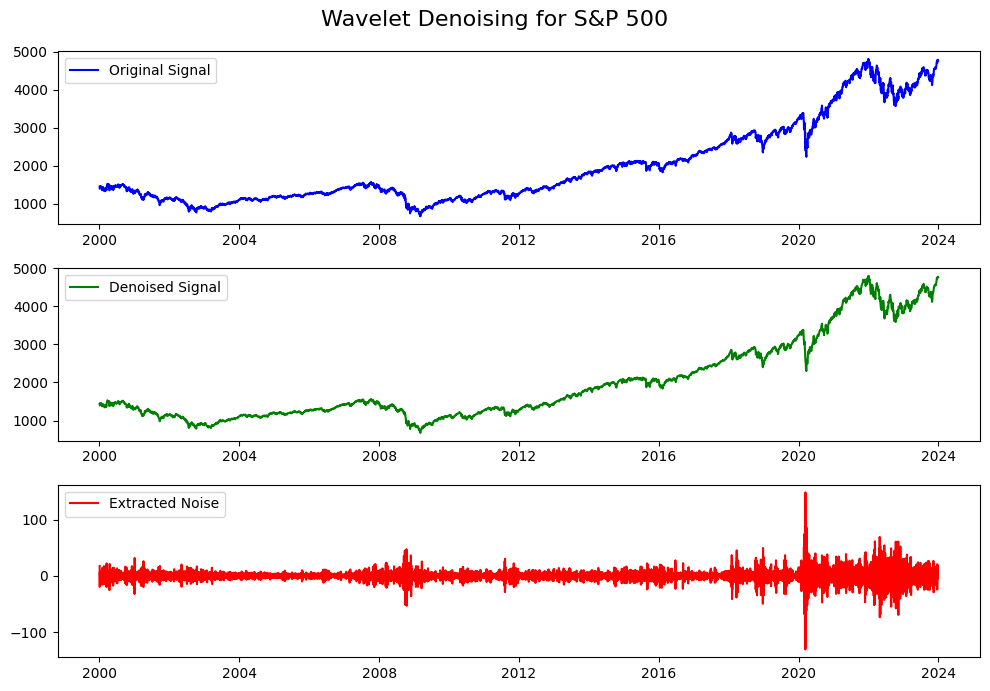

In [12]:
plot_wavelet_denoising(df, STOCK)  # 调用函数绘制去噪结果
# df 的维度是 (时间点数量, 特征数量)，其中包含 'Close'，'Close_denoised' 和 'Noise' 等列

In [13]:
# 将 Date 列转换为无时区信息的 datetime
df = process_dates(df)  # 调用 process_dates 函数处理 DataFrame df 中的日期列，使其变为无时区信息
#  df 的维度在 process_dates 函数内部被处理，该函数会修改 df 的 'Date' 列，但不会改变 df 的整体维度
#  df 的维度仍然是 (时间点数量, 特征数量)

df.head()  # 显示 DataFrame df 的前几行
# df 的维度是 (时间点数量, 特征数量)


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_denoised,Noise
Date,,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0.0,0.0,1437.676407,17.543564
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0.0,0.0,1419.029236,-19.609192
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.0,0.0,1395.549382,6.560603
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.0,0.0,1402.983594,0.466357
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.0,0.0,1445.805988,-4.336018


In [14]:
#!pip install darts
!pip install darts==0.30.0

In [15]:
# src/ml/models/darts/preprocessing.py

# -------------------------------------------------------------------------------------------
# Darts 库:
#
# - 论文: https://www.jmlr.org/papers/v23/21-1177.html
# - 文档: https://unit8co.github.io/darts/README.html#
# - 仓库: https://github.com/unit8co/darts
# -------------------------------------------------------------------------------------------

import datetime  # 导入 datetime 模块，用于处理日期和时间
import pandas as pd  # 导入 pandas 模块，用于处理数据，特别是 DataFrame
from darts import TimeSeries  # 导入 darts 库中的 TimeSeries 类，用于处理时间序列数据
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday # 导入pandas 假日相关类
from darts.dataprocessing.transformers.scaler import Scaler  # 导入 darts 库中的 Scaler 类，用于数据缩放

# -------------------------------------------------------------------------------------------
# 转换为 darts TimeSeries
# -------------------------------------------------------------------------------------------

def _get_ts_series(times, values):
    """
    将时间和值转换为 darts TimeSeries 对象。

    参数:
        times (pandas.DatetimeIndex): 时间索引。 (维度: (时间点数量,))
        values (numpy.ndarray): 与时间索引对应的值。 (维度: (时间点数量, 特征数量))

    返回:
        darts.TimeSeries: 包含时间和值的 TimeSeries 对象。
    """
    series = TimeSeries.from_times_and_values(times=times, values=values)  # 创建 TimeSeries 对象
    assert not pd.isna(series.pd_dataframe()).any().any(), "Darts time series contains NaN values"  # 确保 TimeSeries 不包含 NaN 值
    return series

def _adjust_for_dst(df, freq, min_hour):
    """
    调整 DataFrame 的时间索引，以处理夏令时 (DST) 转换。

    参数:
        df (pandas.DataFrame): 包含时间索引的 DataFrame。
            DataFrame 的索引是日期时间。
            (DataFrame 维度: (时间点数量, 特征数量))
        freq (str): 时间序列的频率字符串 (例如 '1H', '1D')。
        min_hour (datetime.time): 最小小时。

    返回:
        pandas.DatetimeIndex: 调整后的日期时间索引。
    """
    df = df.copy()  # 创建 DataFrame 的副本，以避免修改原始数据
    df['date'] = df.index.normalize()  # 创建包含日期的 'date' 列
    adjusted_dates = []  # 初始化空列表，用于存储调整后的日期

    for _, group in df.groupby('date'):  # 按日期分组
        hour_diff = group.index[0].hour - min_hour.hour  # 计算每组第一个小时与最小小时的差值

        if hour_diff == 1:  # 过渡到夏令时 (春季向前拨)
            adjusted_group = group.index - datetime.timedelta(hours=1)  # 减去 1 小时
            adjusted_dates.extend(adjusted_group)  # 将调整后的日期添加到列表中
        elif hour_diff == -1:  # 从夏令时返回 (秋季向后拨)
            adjusted_group = group.index + datetime.timedelta(hours=1)  # 加上 1 小时
            adjusted_dates.extend(adjusted_group)  # 将调整后的日期添加到列表中
        else:  # 没有变化
            adjusted_dates.extend(group.index)  # 直接添加原始日期

    return pd.DatetimeIndex(adjusted_dates, freq=freq)  # 创建并返回调整后的 DatetimeIndex

def convert_to_ts_hourly(df):
    """
    将 DataFrame 转换为小时级别的 darts TimeSeries 对象。

    参数:
        df (pandas.DataFrame): 包含日期时间索引和 'Close' (收盘价) 列的 DataFrame。
            (DataFrame 维度: (时间点数量, 特征数量), 必须包含 'Close')

    返回:
        tuple: 包含两个 darts TimeSeries 对象的元组：
            - 第一个是 'Close' 列的 TimeSeries。
            - 第二个是 'Close_denoised' 列的 TimeSeries。
    """
    # 找到默认营业时间
    min_date = df.index.min().normalize()  # 获取最早日期并标准化
    df_min_date = df[df.index.normalize() == min_date]  # 筛选出最早日期的数据

    min_hour = df_min_date.index.min()  # 获取最早时间
    max_hour = (df_min_date.index.max() + datetime.timedelta(hours=1))  # 获取最晚时间并加 1 小时

    min_hour_str = str(min_hour.strftime('%H:%M'))  # 将最早时间格式化为字符串
    max_hour_str = str(max_hour.strftime('%H:%M'))  # 将最晚时间格式化为字符串

    # 创建包含该范围内所有工作日的完整日期范围
    min_date = df.index.min()
    max_date = df.index.max()

    bhour_mon = pd.offsets.CustomBusinessHour(start=min_hour_str, end=max_hour_str)  # 创建自定义工作时间偏移
    complete_date_range = pd.date_range(start=min_date, end=max_date, freq=bhour_mon)  # 创建完整日期范围 (维度: (时间点数量,))

    # 调整索引
    adjusted_index = _adjust_for_dst(df, bhour_mon, min_hour)  # 调整日期以处理夏令时

    # 将调整后的索引应用于 DataFrame
    df.index = adjusted_index  # (维度: (时间点数量, 特征数量))

    # 按新索引对 DataFrame 排序以确保顺序
    df = df.sort_index()  # (维度: (时间点数量, 特征数量))

    series = _get_ts_series(times=complete_date_range, values=df['Close'].values)  # 从 'Close' 列创建 TimeSeries (维度: (时间点数量,))
    series_denoised = _get_ts_series(times=complete_date_range, values=df['Close_denoised'].values)  # 从 'Close_denoised' 列创建 TimeSeries (维度: (时间点数量,))

    return series, series_denoised  # 返回两个 TimeSeries 对象

def convert_to_ts_daily(df):
    """
    将 DataFrame 转换为每日级别的 darts TimeSeries 对象。

    参数:
        df (pandas.DataFrame): 包含日期时间索引和 'Close' (收盘价) 列的 DataFrame。
            (DataFrame 维度: (时间点数量, 特征数量), 必须包含 'Close')

    返回:
        tuple: 包含两个 darts TimeSeries 对象的元组：
            - 第一个是 'Close' 列的 TimeSeries。
            - 第二个是 'Close_denoised' 列的 TimeSeries。
    """
    # 创建包含该范围内所有工作日的完整日期范围
    min_date = df.index.min()
    max_date = df.index.max()
    complete_date_range = pd.date_range(start=min_date, end=max_date, freq='B')  # 创建完整日期范围 (维度: (时间点数量,))

    # 识别缺失的日期
    existing_dates = df.index
    missing_dates = complete_date_range.difference(existing_dates)  # 计算缺失的日期 (维度: (缺失日期数量,))

    my_holidays = missing_dates.strftime('%Y-%m-%d').tolist()  # 将缺失日期转换为字符串列表

    # 将日期数组转换为 datetime 格式
    my_holidays = pd.to_datetime(my_holidays)  # (维度: (缺失日期数量,))

    # 创建 Holiday 对象列表
    holiday_rules = [Holiday(name=f"CustomHoliday{idx}", year=date.year, month=date.month, day=date.day, observance=nearest_workday) for idx, date in enumerate(my_holidays)]

    # 创建自定义假日日历
    class MyHolidayCalendar(AbstractHolidayCalendar):
        rules = holiday_rules

    # 创建自定义工作日偏移
    custom_bday = pd.offsets.CustomBusinessDay(calendar=MyHolidayCalendar())  # 使用自定义假日日历创建工作日偏移

    # 使用此自定义工作日偏移
    times = pd.DatetimeIndex(df.index, freq=custom_bday)  # 使用自定义工作日偏移创建日期时间索引 (维度: (时间点数量,))

    series = _get_ts_series(times=times, values=df['Close'])  # 从 'Close' 列创建 TimeSeries (维度: (时间点数量,))
    series_denoised = _get_ts_series(times=times, values=df['Close_denoised'])  # 从 'Close_denoised' 列创建 TimeSeries (维度: (时间点数量,))

    return series, series_denoised  # 返回两个 TimeSeries 对象

# -------------------------------------------------------------------------------------------
# 训练集、验证集和测试集划分
# -------------------------------------------------------------------------------------------

def split_train_val_test_darts(series, train_end_date, val_end_date):
    """
    将 darts TimeSeries 对象划分为训练集、验证集和测试集。

    参数:
        series (darts.TimeSeries): 要划分的时间序列。
        train_end_date (str): 训练集结束日期字符串 (YYYY-MM-DD)。
        val_end_date (str): 验证集结束日期字符串 (YYYY-MM-DD)。

    返回:
        tuple: 包含三个 darts TimeSeries 对象的元组：(train, val, test)。
    """
    # 按日期划分数据
    train, temp = series.split_before(pd.Timestamp(train_end_date))  # 将序列在 train_end_date 之前分割成训练集和临时集
    # train: (时间点数量1,)
    # temp: (时间点数量2,)  其中 时间点数量1 + 时间点数量2 =  series 的时间点数量

    val, test = temp.split_before(pd.Timestamp(val_end_date))  # 将临时序列在 val_end_date 之前分割成验证集和测试集
    # val: (时间点数量3,)
    # test: (时间点数量4,)  其中 时间点数量3 + 时间点数量4  = 时间点数量2

    return train, val, test  # 返回划分后的训练集、验证集和测试集

# -------------------------------------------------------------------------------------------
# 归一化数据
# -------------------------------------------------------------------------------------------

def normalise_data_darts(data, scaler=None):
    """
    归一化 darts TimeSeries 对象。

    参数:
        data (darts.TimeSeries): 要归一化的时间序列。 (维度: (时间点数量,))
        scaler (darts.dataprocessing.transformers.scaler.Scaler, 可选):
            可选的 Scaler 对象。如果提供，则使用此缩放器进行转换。
            如果为 None，则创建一个新的 Scaler。

    返回:
        tuple 或 darts.TimeSeries:
            - 如果提供了 scaler，则返回归一化后的 TimeSeries。
            - 否则，返回一个包含归一化后的 TimeSeries 和 Scaler 对象的元组。
    """
    if scaler:
        return scaler.transform(data)  # 使用提供的缩放器转换数据 (维度: (时间点数量,))
    else:
        scaler = Scaler()  # 默认使用 sklearn 的 MinMaxScaler
        data = scaler.fit_transform(data)  # 拟合缩放器并转换数据 (维度: (时间点数量,))
        return data, scaler  # 返回归一化后的数据和缩放器

def inverse_normalise_data_darts(data, scaler):
    """
    反归一化 darts TimeSeries 对象。

    参数:
        data (darts.TimeSeries): 要反归一化的时间序列。 (维度: (时间点数量,))
        scaler (darts.dataprocessing.transformers.scaler.Scaler):
            用于反归一化的 Scaler 对象。

    返回:
        darts.TimeSeries: 反归一化后的时间序列。 (维度: (时间点数量,))
    """
    return scaler.inverse_transform(data)  # 使用提供的缩放器反转转换数据

def normalise_split_data_darts(train, val, test):
    """
    归一化训练集、验证集和测试集。

    参数:
        train (darts.TimeSeries): 训练集时间序列。 (维度: (训练集时间点数量,))
        val (darts.TimeSeries): 验证集时间序列。   (维度: (验证集时间点数量,))
        test (darts.TimeSeries): 测试集时间序列。  (维度: (测试集时间点数量,))

    返回:
        tuple: 包含归一化后的训练集、验证集、测试集和 Scaler 对象的元组。
    """
    train, scaler = normalise_data_darts(train)  # 归一化训练集并获取缩放器
    val = normalise_data_darts(val, scaler)  # 使用训练集的缩放器归一化验证集
    test = normalise_data_darts(test, scaler)  # 使用训练集的缩放器归一化测试集

    return train, val, test, scaler  # 返回归一化后的数据集和缩放器


In [16]:
series, series_denoised = convert_to_ts_daily(df)  # 将 DataFrame df 转换为每日级别的 darts TimeSeries 对象，并分别赋值给 series 和 series_denoised
# df 的维度是 (时间点数量, 特征数量)
# series 和 series_denoised 的维度都是 (时间点数量,)，表示每日的收盘价时间序列

series_denoised  # 显示变量 series_denoised
# series_denoised 的维度是 (时间点数量,)，表示每日的去噪后收盘价时间序列


<TimeSeries (DataArray) (Date: 6037, component: 1, sample: 1)> Size: 48kB
array([[[1437.6764069 ]],

       [[1419.02923629]],

       [[1395.54938238]],

       ...,

       [[4781.45492258]],

       [[4782.76373207]],

       [[4771.75571991]]])
Coordinates:
  * Date       (Date) datetime64[ns] 48kB 2000-01-03 2000-01-04 ... 2023-12-29
  * component  (component) <U1 4B '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

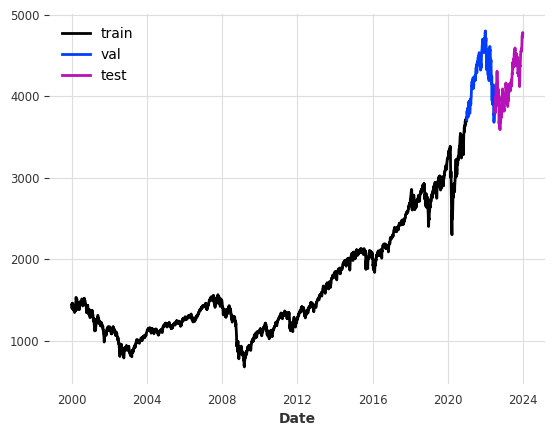

In [17]:
# from ml.models.darts.preprocessing import split_train_val_test_darts  # 注释掉的导入语句

import datetime # 导入日期时间模块

# 将字符串日期转换为 datetime 对象
TRAIN_END_DATE = datetime.datetime.strptime(TRAIN_END_DATE, '%Y-%m-%d')  # 将训练集结束日期字符串转换为 datetime 对象
VAL_END_DATE = datetime.datetime.strptime(VAL_END_DATE, '%Y-%m-%d')  # 将验证集结束日期字符串转换为 datetime 对象
# TRAIN_END_DATE 和 VAL_END_DATE 现在是 datetime 类型，不再是字符串

train, val, test = split_train_val_test_darts(series, TRAIN_END_DATE, VAL_END_DATE)  # 使用处理后的日期分割原始时间序列
# 调用 split_train_val_test_darts 函数，根据指定的日期将时间序列分割为训练集、验证集和测试集
# train, val, test 的维度均为 (训练集/验证集/测试集时间点数量,)，类型为 darts.TimeSeries
train_denoised, val_denoised, test_denoised = split_train_val_test_darts(series_denoised, TRAIN_END_DATE, VAL_END_DATE)  # 对去噪后的时间序列进行相同的分割
# 调用 split_train_val_test_darts 函数，分割去噪后的时间序列
# train_denoised, val_denoised, test_denoised 的维度与 train, val, test 相同，均为 (训练集/验证集/测试集时间点数量,)，类型为 darts.TimeSeries

train_denoised.plot(label="train");  # 绘制去噪后训练集的时间序列
val_denoised.plot(label="val");  # 绘制去噪后验证集的时间序列
test_denoised.plot(label="test");  # 绘制去噪后测试集的时间序列
# 这些 plot 函数调用会生成图表，显示去噪后数据在不同数据集上的时间序列变化


In [18]:
train, val, test, scaler_darts = normalise_split_data_darts(train, val, test) # 归一化训练集、验证集和测试集，并获取归一化器
# train, val, test: 在归一化前，维度分别为 (训练集时间点数量,), (验证集时间点数量,), (测试集时间点数量,)
# train, val, test: 归一化后，维度不变，仍然分别为 (训练集时间点数量,), (验证集时间点数量,), (测试集时间点数量,)，但数据值已缩放到 [0, 1] 或其他指定范围
# scaler_darts: 归一化器对象，用于后续反归一化

train_denoised, val_denoised, test_denoised, scaler_darts_denoised = normalise_split_data_darts(train_denoised, val_denoised, test_denoised) # 归一化去噪后的训练集、验证集和测试集，并获取归一化器
# train_denoised, val_denoised, test_denoised: 在归一化前，维度分别为 (训练集时间点数量,), (验证集时间点数量,), (测试集时间点数量,)
# train_denoised, val_denoised, test_denoised: 归一化后，维度不变，仍然分别为  (训练集时间点数量,), (验证集时间点数量,), (测试集时间点数量,)，但数据值已缩放到 [0, 1] 或其他指定范围
# scaler_darts_denoised: 归一化器对象，用于后续反归一化


In [19]:
# src/ml/xlstm_ts/preprocessing.py

from sklearn.preprocessing import MinMaxScaler  # 导入 sklearn 的 MinMaxScaler，用于数据归一化
import numpy as np  # 导入 numpy，用于数值计算
import pandas as pd  # 导入 pandas，用于数据处理，特别是 Series
import torch  # 导入 torch，用于创建和操作张量
# from ml.constants import SEQ_LENGTH_XLSTM  # 注释掉的导入
# from ml.utils.visualisation import plot_data_split  # 注释掉的导入


# -------------------------------------------------------------------------------------------
# 归一化数据
# -------------------------------------------------------------------------------------------

def normalise_data_xlstm(data):
    """
    归一化数据到 [0, 1] 范围。

    参数:
        data (numpy.ndarray): 要归一化的数据。
            (维度: (时间点数量, 1) 或者 (时间点数量,))

    返回:
        tuple: 包含归一化后的数据和用于反归一化的 MinMaxScaler 对象。
            - 归一化后的数据 (numpy.ndarray): (维度: (时间点数量, 1))
            - MinMaxScaler 对象: 用于后续反归一化
    """
    scaler = MinMaxScaler(feature_range=(0, 1))  # 创建 MinMaxScaler 对象，设置归一化范围为 [0, 1]
    return scaler.fit_transform(data.reshape(-1, 1)), scaler  # 归一化数据并返回归一化后的数据和 scaler

def inverse_normalise_data_xlstm(data, scaler):
    """
    反归一化数据。

    参数:
        data (torch.Tensor 或 numpy.ndarray): 要反归一化的数据。 (维度: (时间点数量, 1))
        scaler (MinMaxScaler): 用于反归一化的 MinMaxScaler 对象。

    返回:
        numpy.ndarray: 反归一化后的数据。 (维度: (时间点数量, 1))
    """
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    return scaler.inverse_transform(data.reshape(-1, 1))  # 反归一化数据

# -------------------------------------------------------------------------------------------
# 创建序列
# -------------------------------------------------------------------------------------------

# 创建序列的函数
def create_sequences(data, dates):
    """
    将数据和日期转换为 LSTM 模型所需的序列格式。

    参数:
        data (numpy.ndarray): 输入数据。 (维度: (时间点数量, 1))
        dates (pandas.Series): 与输入数据对应的时间序列。 (维度: (时间点数量,))

    返回:
        tuple: 包含输入序列、输出序列和对应的日期序列的元组。
            - 输入序列 X (torch.Tensor): (维度: (序列数量, SEQ_LENGTH_XLSTM, 1))
            - 输出序列 y (torch.Tensor): (维度: (序列数量, 1))
            - 日期序列 dates (pandas.Series): (维度: (序列数量,))
    """
    xs, ys, date_list = [], [], []  # 初始化存储输入序列、输出序列和日期列表的列表
    SEQ_LENGTH_XLSTM = 20

    for i in range(len(data) - SEQ_LENGTH_XLSTM):  # 遍历数据，创建序列
        x = data[i:i + SEQ_LENGTH_XLSTM]  # 获取一个长度为 SEQ_LENGTH_XLSTM 的输入序列 (维度: (SEQ_LENGTH_XLSTM, 1))
        y = data[i + SEQ_LENGTH_XLSTM]  # 获取序列对应的输出值 (维度: (1,))
        date = dates[i + SEQ_LENGTH_XLSTM]  # 获取序列对应的日期
        xs.append(x)  # 将输入序列添加到列表中
        ys.append(y)  # 将输出值添加到列表中
        date_list.append(date)  # 将日期添加到列表中

    X = np.array(xs)  # 将输入序列列表转换为 numpy 数组 (维度: (序列数量, SEQ_LENGTH_XLSTM, 1))
    y = np.array(ys)  # 将输出值列表转换为 numpy 数组 (维度: (序列数量, 1))
    dates = pd.Series(date_list)  # 将日期列表转换为 pandas Series (维度: (序列数量,))

    # 转换为 PyTorch 张量
    X = torch.from_numpy(X).float()  # 将输入序列转换为 PyTorch 张量，并转换为 float 类型 (维度: (序列数量, SEQ_LENGTH_XLSTM, 1))
    y = torch.from_numpy(y).float()  # 将输出值转换为 PyTorch 张量，并转换为 float 类型 (维度: (序列数量, 1))

    return X, y, dates  # 返回输入序列、输出序列和日期序列

# -------------------------------------------------------------------------------------------
# 训练集、验证集和测试集划分
# -------------------------------------------------------------------------------------------

def _split_data(x, y, dates, set, train_end_date, val_end_date):
    """
    将数据划分为训练集、验证集或测试集。

    参数:
        x (torch.Tensor): 输入序列。 (维度: (序列数量, SEQ_LENGTH_XLSTM, 1))
        y (torch.Tensor): 输出序列。 (维度: (序列数量, 1))
        dates (pandas.Series): 与序列对应的日期序列。 (维度: (序列数量,))
        set (str): 要划分的数据集类型，必须是 'train'、'val' 或 'test'。
        train_end_date (datetime.datetime): 训练集结束日期。
        val_end_date (datetime.datetime): 验证集结束日期。

    返回:
        tuple: 包含划分后的输入序列、输出序列和日期序列的元组。
            - 划分后的输入序列 x (torch.Tensor): (维度: (划分后的序列数量, SEQ_LENGTH_XLSTM, 1))
            - 划分后的输出序列 y (torch.Tensor): (维度: (划分后的序列数量, 1))
            - 划分后的日期序列 dates (pandas.Series): (维度: (划分后的序列数量,))
    """
    if set == 'train':
        mask = (dates < train_end_date)  # 创建训练集掩码
    elif set == 'val':
        mask = (dates >= train_end_date) & (dates < val_end_date)  # 创建验证集掩码
    elif set == 'test':
        mask = (dates >= val_end_date)  # 创建测试集掩码
    else:
        raise ValueError("Invalid set name. Must be 'train', 'val', or 'test'.")  # 如果 set 参数无效，则抛出异常

    # 移动数据到 GPU
    x_splitted = x[mask].to('cuda')  # 根据掩码划分输入序列，并移动到 GPU
    y_splitted = y[mask].to('cuda')  # 根据掩码划分输出序列，并移动到 GPU

    print(f"{set} X shape: {x_splitted.shape}")  # 打印划分后的输入序列的形状
    print(f"{set} y shape: {y_splitted.shape}")  # 打印划分后的输出序列的形状

    return x_splitted, y_splitted, dates[mask]  # 返回划分后的数据

def split_train_val_test_xlstm(x, y, dates, train_end_date, val_end_date, scaler, stock):
    """
    将数据划分为训练集、验证集和测试集，并绘制划分结果。

    参数:
        x (torch.Tensor): 输入序列。 (维度: (序列数量, SEQ_LENGTH_XLSTM, 1))
        y (torch.Tensor): 输出序列。 (维度: (序列数量, 1))
        dates (pandas.Series): 与序列对应的日期序列。 (维度: (序列数量,))
        train_end_date (datetime.datetime): 训练集结束日期。
        val_end_date (datetime.datetime): 验证集结束日期。
        scaler (MinMaxScaler): 用于反归一化数据的 MinMaxScaler 对象。
        stock (str): 股票名称，用于绘制图表。

    返回:
        tuple: 包含划分后的训练集、验证集和测试集的输入序列、输出序列和日期序列的元组。
            (train_x, train_y, train_dates, val_x, val_y, val_dates, test_x, test_y, test_dates)
    """
    train_x, train_y, train_dates = _split_data(x, y, dates, 'train', train_end_date, val_end_date)  # 划分训练集
    val_x, val_y, val_dates = _split_data(x, y, dates, 'val', train_end_date, val_end_date)  # 划分验证集
    test_x, test_y, test_dates = _split_data(x, y, dates, 'test', train_end_date, val_end_date)  # 划分测试集

    #  注释掉的绘图函数
    # plot_data_split(
    #     train_dates.to_numpy(), inverse_normalise_data_xlstm(train_y, scaler),
    #     val_dates.to_numpy(), inverse_normalise_data_xlstm(val_y, scaler),
    #     test_dates.to_numpy(), inverse_normalise_data_xlstm(test_y, scaler),
    #     stock
    # )  # 绘制划分后的数据

    return train_x, train_y, train_dates, val_x, val_y, val_dates, test_x, test_y, test_dates  # 返回划分后的数据


In [20]:
# from ml.models.xlstm_ts.preprocessing import normalise_data_xlstm # 注释掉的导入语句

close_scaled, scaler = normalise_data_xlstm(df['Close'].values)  # 归一化 'Close' 列的数据
# df['Close'].values 的维度为 (时间点数量,)
# normalise_data_xlstm 的返回值:
#     - close_scaled 的维度为 (时间点数量, 1)，表示归一化后的收盘价
#     - scaler 是 MinMaxScaler 对象，用于后续反归一化

close_scaled_denoised, scaler_denoised = normalise_data_xlstm(df['Close_denoised'].values)  # 归一化 'Close_denoised' 列的数据
# df['Close_denoised'].values 的维度为 (时间点数量,)
# normalise_data_xlstm 的返回值:
#     - close_scaled_denoised 的维度为 (时间点数量, 1)，表示归一化后的去噪收盘价
#     - scaler_denoised 是 MinMaxScaler 对象，用于后续反归一化


In [21]:
X, y, dates = create_sequences(close_scaled, df.index)  # 使用归一化后的收盘价数据和原始 DataFrame 的索引创建输入序列 X、输出序列 y 和日期序列 dates
# close_scaled 的维度为 (时间点数量, 1)
# df.index 的维度为 (时间点数量,)
# create_sequences 的返回值:
#     - X 的维度为 (序列数量, SEQ_LENGTH_XLSTM, 1)
#     - y 的维度为 (序列数量, 1)
#     - dates 的维度为 (序列数量,)

X_denoised, y_denoised, _ = create_sequences(close_scaled_denoised, df.index)  # 使用归一化后的去噪收盘价数据和原始 DataFrame 的索引创建输入序列 X_denoised、输出序列 y_denoised 和日期序列 (忽略)
# close_scaled_denoised 的维度为 (时间点数量, 1)
# df.index 的维度为 (时间点数量,)
# create_sequences 的返回值:
#     - X_denoised 的维度为 (序列数量, SEQ_LENGTH_XLSTM, 1)
#     - y_denoised 的维度为 (序列数量, 1)
#     - _ (忽略) 的维度为 (序列数量,)


In [22]:
train_X, train_y, train_dates, val_X, val_y, val_dates, test_X, test_y, test_dates = split_train_val_test_xlstm(X, y, dates, TRAIN_END_DATE, VAL_END_DATE, scaler, STOCK)
# 使用 split_train_val_test_xlstm 函数将数据划分为训练集、验证集和测试集
# 参数:
#   - X: 输入序列 (维度: (序列总数, SEQ_LENGTH_XLSTM, 1))
#   - y: 输出序列 (维度: (序列总数, 1))
#   - dates: 日期序列 (维度: (序列总数,))
#   - TRAIN_END_DATE: 训练集结束日期
#   - VAL_END_DATE: 验证集结束日期
#   - scaler: 用于反归一化的 MinMaxScaler 对象
#   - STOCK: 股票名称

# 返回值:
#   - train_X: 训练集输入序列 (维度: (训练集序列数, SEQ_LENGTH_XLSTM, 1))
#   - train_y: 训练集输出序列 (维度: (训练集序列数, 1))
#   - train_dates: 训练集日期序列 (维度: (训练集序列数,))
#   - val_X: 验证集输入序列 (维度: (验证集序列数, SEQ_LENGTH_XLSTM, 1))
#   - val_y: 验证集输出序列 (维度: (验证集序列数, 1))
#   - val_dates: 验证集日期序列 (维度: (验证集序列数,))
#   - test_X: 测试集输入序列 (维度: (测试集序列数, SEQ_LENGTH_XLSTM, 1))
#   - test_y: 测试集输出序列 (维度: (测试集序列数, 1))
#   - test_dates: 测试集日期序列 (维度: (测试集序列数,))


train X shape: torch.Size([5264, 20, 1])
train y shape: torch.Size([5264, 1])
val X shape: torch.Size([376, 20, 1])
val y shape: torch.Size([376, 1])
test X shape: torch.Size([377, 20, 1])
test y shape: torch.Size([377, 1])


In [23]:
train_X_denoised, train_y_denoised, _, val_X_denoised, val_y_denoised, _, test_X_denoised, test_y_denoised, _ = split_train_val_test_xlstm(X_denoised, y_denoised, dates, TRAIN_END_DATE, VAL_END_DATE, scaler_denoised, STOCK)
# 使用 split_train_val_test_xlstm 函数将去噪后的数据划分为训练集、验证集和测试集
# 参数:
#   - X_denoised: 去噪后的输入序列 (维度: (序列总数, SEQ_LENGTH_XLSTM, 1))
#   - y_denoised: 去噪后的输出序列 (维度: (序列总数, 1))
#   - dates: 日期序列 (维度: (序列总数,))
#   - TRAIN_END_DATE: 训练集结束日期
#   - VAL_END_DATE: 验证集结束日期
#   - scaler_denoised: 用于反归一化去噪后数据的 MinMaxScaler 对象
#   - STOCK: 股票名称

# 返回值:
#   - train_X_denoised: 去噪后的训练集输入序列 (维度: (训练集序列数, SEQ_LENGTH_XLSTM, 1))
#   - train_y_denoised: 去噪后的训练集输出序列 (维度: (训练集序列数, 1))
#   - _: 去噪后的训练集日期序列 (维度: (训练集序列数,))  <--  此处的 "_" 表示我们不使用这个返回值
#   - val_X_denoised: 去噪后的验证集输入序列 (维度: (验证集序列数, SEQ_LENGTH_XLSTM, 1))
#   - val_y_denoised: 去噪后的验证集输出序列 (维度: (验证集序列数, 1))
#   - _: 去噪后的验证集日期序列 (维度: (验证集序列数,))  <--  此处的 "_" 表示我们不使用这个返回值
#   - test_X_denoised: 去噪后的测试集输入序列 (维度: (测试集序列数, SEQ_LENGTH_XLSTM, 1))
#   - test_y_denoised: 去噪后的测试集输出序列 (维度: (测试集序列数, 1))
#   - _: 去噪后的测试集日期序列 (维度: (测试集序列数,))  <--  此处的 "_" 表示我们不使用这个返回值


train X shape: torch.Size([5264, 20, 1])
train y shape: torch.Size([5264, 1])
val X shape: torch.Size([376, 20, 1])
val y shape: torch.Size([376, 1])
test X shape: torch.Size([377, 20, 1])
test y shape: torch.Size([377, 1])


In [24]:
# src/ml/models/shared/directional_prediction.py

import numpy as np  # 导入 numpy，用于数值计算
import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot，用于绘图
import seaborn as sns  # 导入 seaborn，用于绘制更美观的图表
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score  # 导入 sklearn 的评估指标

# -------------------------------------------------------------------------------------------
# 预测方向
# -------------------------------------------------------------------------------------------

def calculate_directions(data):
    """
    计算数据中每个时间点的方向（上涨或下跌）。

    参数:
        data (numpy.ndarray): 包含时间序列数据的 numpy 数组。 (维度: (时间点数量,))

    返回:
        numpy.ndarray: 包含方向信息的 numpy 数组，其中 [0, 1] 表示上涨，[1, 0] 表示下跌。
            (维度: (时间点数量 - 1, 2))
    """
    directions = np.diff(data.squeeze())  # 计算数据的一阶差分，得到每个时间点的变化量。 squeeze()移除长度为1的维度
    directional_data = np.zeros((directions.size, 2))  # 创建一个用于存储方向信息的数组，初始化为全零 (维度: (时间点数量 - 1, 2))
    for i, diff in enumerate(directions):  # 遍历差分数组
        if diff > 0:
            directional_data[i] = [0, 1]  # 如果差分大于 0，则表示上涨，将对应位置设为 [0, 1]
        else:
            directional_data[i] = [1, 0]  # 否则，表示下跌，将对应位置设为 [1, 0]
    return directional_data  # 返回包含方向信息的数组

def calculate_movement_metrics(true_labels, predicted_labels, model_name, set_type, data_type):
    """
    计算模型预测方向的评估指标。

    参数:
        true_labels (numpy.ndarray): 真实的类别标签（0: 下跌, 1: 上涨）。 (维度: (样本数量,))
        predicted_labels (numpy.ndarray): 模型预测的类别标签（0: 下跌, 1: 上涨）。 (维度: (样本数量,))
        model_name (str): 模型名称，用于打印信息。
        set_type (str): 数据集类型，例如 "Train"、"Val" 或 "Test"。
        data_type (str): 数据类型，例如 "Raw" 或 "Denoised"。

    返回:
        dict: 包含评估指标的字典。
            对于训练集和验证集，只返回 'Accuracy'。
            对于测试集，返回 'Accuracy', 'Recall', 'Precision (Rise)', 'Precision (Fall)', 'F1 Score'。
    """
    if set_type == "Train":
        # 计算训练集的准确率
        accuracy = accuracy_score(true_labels, predicted_labels) * 100  # 计算准确率并转换为百分比
        print(f'{model_name} ({data_type}) | Train Accuracy: {accuracy:.2f}%')

        return {'Train Accuracy': accuracy}  # 返回包含准确率的字典

    if set_type == "Val":
        # 计算验证集的准确率
        accuracy = accuracy_score(true_labels, predicted_labels) * 100  # 计算准确率并转换为百分比
        print(f'{model_name} ({data_type}) | Validation Accuracy: {accuracy:.2f}%')

        return {'Validation Accuracy': accuracy}  # 返回包含准确率的字典

    elif set_type == "Test":
        # 计算测试集的评估指标
        accuracy = accuracy_score(true_labels, predicted_labels) * 100  # 计算准确率并转换为百分比
        recall = recall_score(true_labels, predicted_labels, pos_label=1) * 100  # 计算召回率 (上涨) 并转换为百分比
        precision_rise = precision_score(true_labels, predicted_labels, pos_label=1) * 100  # 计算上涨的精确率并转换为百分比
        precision_fall = precision_score(true_labels, predicted_labels, pos_label=0) * 100  # 计算下跌的精确率并转换为百分比
        f1 = f1_score(true_labels, predicted_labels, pos_label=1) * 100  # 计算 F1 分数 (上涨) 并转换为百分比

        print(f'{model_name} ({data_type}) | Test Accuracy: {accuracy:.2f}%')
        print(f'{model_name} ({data_type}) | Recall: {recall:.2f}%')
        print(f'{model_name} ({data_type}) | Precision (Rise): {precision_rise:.2f}%')
        print(f'{model_name} ({data_type}) | Precision (Fall): {precision_fall:.2f}%')
        print(f'{model_name} ({data_type}) | F1 Score: {f1:.2f}%')

        # 混淆矩阵
        cm = confusion_matrix(true_labels, predicted_labels)  # 计算混淆矩阵 (维度: (2, 2))
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # 计算归一化后的混淆矩阵 (维度: (2, 2))

        plt.figure(figsize=(10, 7))  # 创建一个图形
        sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=["Down", "Up"], yticklabels=["Down", "Up"], cbar=False)  # 绘制混淆矩阵的热图

        # 添加百分比
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j + 0.5, i + 0.55, f'\n({cm_norm[i, j]:.2%})',  # 在每个单元格中添加百分比文本
                         horizontalalignment='center',
                         verticalalignment='center',
                         color='black',
                         fontsize=9)

        plt.xlabel('Predicted')  # 设置 x 轴标签
        plt.ylabel('True')  # 设置 y 轴标签
        plt.title(f'{model_name} Confusion Matrix ({data_type} Data)')  # 设置图表标题
        plt.show()  # 显示图表

        return {  # 返回包含所有计算指标的字典
            'Test Accuracy': accuracy,
            'Recall': recall,
            'Precision (Rise)': precision_rise,
            'Precision (Fall)': precision_fall,
            'F1 Score': f1
        }

def evaluate_directional_movement(actual_values_train, backtest_train, actual_values_val, backtest_val, actual_values_test, backtest_test, model_name, data_type, using_darts=True):
    """
    评估模型预测方向的性能，并返回测试集的预测结果和评估指标。

    参数:
        actual_values_train (array-like): 训练集的真实值。  (维度: (训练集时间点数量,))
        backtest_train (array-like): 训练集的模型预测值。 (维度: (训练集时间点数量,))
        actual_values_val (array-like): 验证集的真实值。    (维度: (验证集时间点数量,))
        backtest_val (array-like): 验证集的模型预测值。   (维度: (验证集时间点数量,))
        actual_values_test (array-like): 测试集的真实值。   (维度: (测试集时间点数量,))
        backtest_test (array-like): 测试集的模型预测值。  (维度: (测试集时间点数量,))
        model_name (str): 模型名称，用于打印和绘制结果。
        data_type (str): 数据类型，例如 "Raw" 或 "Denoised"，用于打印和绘制结果。
        using_darts (bool, 可选): 指示是否使用 Darts 库。默认为 True。

    返回:
        tuple: 包含测试集的真实类别标签、预测类别标签和评估指标字典的元组。
            - true_labels_test (numpy.ndarray): 测试集的真实类别标签。 (维度: (测试集时间点数量 - 1,))
            - predicted_labels_test (numpy.ndarray): 测试集的预测类别标签。 (维度: (测试集时间点数量 - 1,))
            - metrics_test (dict): 包含测试集评估指标的字典，以及训练集和验证集的准确率。
    """
    if using_darts:
        train_y = actual_values_train.values()  # 从 Darts TimeSeries 对象中提取 numpy 数组
        train_predictions = backtest_train.values()  # 从 Darts TimeSeries 对象中提取 numpy 数组
        val_y = actual_values_val.values()      # 从 Darts TimeSeries 对象中提取 numpy 数组
        val_predictions = backtest_val.values()    # 从 Darts TimeSeries 对象中提取 numpy 数组
        test_y = actual_values_test.values()    # 从 Darts TimeSeries 对象中提取 numpy 数组
        test_predictions = backtest_test.values()  # 从 Darts TimeSeries 对象中提取 numpy 数组
    else:
        train_y = actual_values_train  # 使用原始 numpy 数组
        train_predictions = backtest_train  # 使用原始 numpy 数组
        val_y = actual_values_val      # 使用原始 numpy 数组
        val_predictions = backtest_val    # 使用原始 numpy 数组
        test_y = actual_values_test    # 使用原始 numpy 数组
        test_predictions = backtest_test  # 使用原始 numpy 数组

    # 计算训练集的方向
    true_directions_train = calculate_directions(train_y)  # (维度: (训练集时间点数量 - 1, 2))
    predicted_directions_train = calculate_directions(train_predictions)  # (维度: (训练集时间点数量 - 1, 2))

    # 转换为训练集的类别标签
    true_labels_train = np.argmax(true_directions_train, axis=1)  # (维度: (训练集时间点数量 - 1,))
    predicted_labels_train = np.argmax(predicted_directions_train, axis=1)  # (维度: (训练集时间点数量 - 1,))

    # 计算验证集的方向
    true_directions_val = calculate_directions(val_y)  # (维度: (验证集时间点数量 - 1, 2))
    predicted_directions_val = calculate_directions(val_predictions)  # (维度: (验证集时间点数量 - 1, 2))

    # 转换为验证集的类别标签
    true_labels_val = np.argmax(true_directions_val, axis=1)  # (维度: (验证集时间点数量 - 1,))
    predicted_labels_val = np.argmax(predicted_directions_val, axis=1)  # (维度: (验证集时间点数量 - 1,))

    # 计算测试集的方向
    true_directions_test = calculate_directions(test_y)  # (维度: (测试集时间点数量 - 1, 2))
    predicted_directions_test = calculate_directions(test_predictions)  # (维度: (测试集时间点数量 - 1, 2))

    # 转换为测试集的类别标签
    true_labels_test = np.argmax(true_directions_test, axis=1)  # (维度: (测试集时间点数量 - 1,))
    predicted_labels_test = np.argmax(predicted_directions_test, axis=1)  # (维度: (测试集时间点数量 - 1,))

    # 计算训练集的指标
    metrics_train = calculate_movement_metrics(true_labels_train, predicted_labels_train, model_name, "Train", data_type)  # 返回一个字典

    # 计算验证集的指标
    metrics_val = calculate_movement_metrics(true_labels_val, predicted_labels_val, model_name, "Val", data_type)  # 返回一个字典

    # 计算测试集的指标
    metrics_test = calculate_movement_metrics(true_labels_test, predicted_labels_test, model_name, "Test", data_type)  # 返回一个字典

    # 将验证集和训练集的准确率合并到测试集的指标字典中
    metrics_test['Validation Accuracy'] = metrics_val['Validation Accuracy']
    metrics_test['Train Accuracy'] = metrics_train['Train Accuracy']

    return true_labels_test, predicted_labels_test, metrics_test  # 返回测试集的真实标签、预测标签和包含所有指标的字典


In [25]:
# src/ml/models/shared/metrics.py

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error, r2_score  # 导入 sklearn 的评估指标
from darts import TimeSeries  # 导入 darts 的 TimeSeries 类
import numpy as np  # 导入 numpy，用于数值计算

# -------------------------------------------------------------------------------------------
# 预测指标
#
# https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9
# -------------------------------------------------------------------------------------------

def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """
    朴素预测方法，直接重复前一个样本。

    参数:
        actual (numpy.ndarray): 真实的观测值。 (维度: (时间点数量,))
        seasonality (int, 可选): 时间序列的季节性周期。默认为 1。

    返回:
        numpy.ndarray: 朴素预测值。 (维度: (时间点数量 - seasonality,))
    """
    # 朴素预测方法，直接重复前一个样本
    return actual[:-seasonality]  # 返回除了最后 seasonality 个元素之外的所有元素

def root_mean_squared_scaled_error(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    计算 RMSSE - 均方根比例误差。

    参数:
        actual (numpy.ndarray): 真实的观测值。 (维度: (时间点数量,))
        predicted (numpy.ndarray): 模型的预测值。 (维度: (时间点数量,))
        seasonality (int, 可选): 时间序列的季节性周期。默认为 1。

    返回:
        float: RMSSE 值。
    """
    # RMSSE - 均方根比例误差
    q = mean_squared_error(actual, predicted) / mean_squared_error(actual[seasonality:], _naive_forecasting(actual, seasonality))  # 计算 RMSSE 的核心部分
    return np.sqrt(q)  # 返回 RMSSE 值

def mean_absolute_scaled_error(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    计算 MASE - 平均绝对比例误差。

    参数:
        actual (numpy.ndarray): 真实的观测值。 (维度: (时间点数量,))
        predicted (numpy.ndarray): 模型的预测值。  (维度: (时间点数量,))
        seasonality (int, 可选): 时间序列的季节性周期。默认为 1。

    返回:
        float: MASE 值。
    """
    # MASE - 平均绝对比例误差
    return mean_absolute_error(actual, predicted) / mean_absolute_error(actual[seasonality:], _naive_forecasting(actual, seasonality))  # 计算并返回 MASE 值

def calculate_metrics(actual, prediction, model_name, data_type):
    """
    计算模型的预测性能指标。

    参数:
        actual (numpy.ndarray 或 darts.TimeSeries): 真实的观测值。 (维度: (时间点数量,))
        prediction (numpy.ndarray 或 darts.TimeSeries): 模型的预测值。 (维度: (时间点数量,))
        model_name (str): 模型名称，用于打印信息。
        data_type (str): 数据类型，例如 "Raw" 或 "Denoised"。

    返回:
        dict: 包含各种评估指标的字典，包括 MAE, MSE, RMSE, RMSSE, MAPE, MASE, R2。
    """
    # 如果需要，将 Darts TimeSeries 转换为 NumPy 数组
    if isinstance(actual, TimeSeries):
        actual = actual.values().flatten()  # (维度: (时间点数量,))
    if isinstance(prediction, TimeSeries):
        prediction = prediction.values().flatten()  # (维度: (时间点数量,))

    # 使用 scikit-learn 函数计算指标
    metrics = {
        "MAE": mean_absolute_error(actual, prediction),  # 平均绝对误差
        "MSE": mean_squared_error(actual, prediction),  # 均方误差
        "RMSE": root_mean_squared_error(actual, prediction),  # 均方根误差
        "RMSSE": root_mean_squared_scaled_error(actual, prediction),  # 均方根比例误差
        "MAPE": mean_absolute_percentage_error(actual, prediction) * 100,  # 平均绝对百分比误差
        "MASE": mean_absolute_scaled_error(actual, prediction),  # 平均绝对比例误差
        "R2": r2_score(actual, prediction)  # 决定系数
    }

    # 打印指标
    for metric_name, metric_value in metrics.items():
        value_str = f"{metric_value:.2f}"  # 将指标值格式化为字符串
        if metric_name == "MAPE":
            value_str += "%"  # 如果是 MAPE，则添加百分号
        print(f"{model_name} ({data_type}) | {metric_name}: {value_str}")  # 打印指标名称和值

    return metrics  # 返回包含所有计算指标的字典


In [26]:
# src/ml/models/shared/visualisation.py

from darts import TimeSeries  # 导入 darts 的 TimeSeries 类
import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot，用于绘图
import numpy as np  # 导入 numpy，用于数值计算
from sklearn.metrics import confusion_matrix  # 导入 sklearn 的 confusion_matrix 函数，用于计算混淆矩阵
import seaborn as sns  # 导入 seaborn，用于绘制更美观的图表

def visualise(actual, prediction, stock, model_name, data_type, show_complete=True, dates=None):
    """
    可视化实际值和预测值。

    参数:
        actual (numpy.ndarray 或 darts.TimeSeries): 真实的观测值。 (维度: (时间点数量,))
        prediction (numpy.ndarray 或 darts.TimeSeries): 模型的预测值。 (维度: (时间点数量,))
        stock (str): 股票名称，用于图表标题。
        model_name (str): 模型名称，用于图表标题。
        data_type (str): 数据类型，例如 "Original" 或 "Denoised"，用于图表标题。
        show_complete (bool, 可选): 是否显示完整数据。默认为 True。
        dates (array-like, 可选): 与数据对应的时间序列。如果 actual 和 prediction 是 TimeSeries 对象，则默认为其时间索引。

    返回:
        None: 此函数不返回任何值，它直接显示图表。
    """
    # 如果 actual 是 TimeSeries 对象，则提取其时间和值
    if isinstance(actual, TimeSeries):
        dates = actual.time_index  # 获取时间索引 (维度: (时间点数量,))
        actual = actual.values().flatten()  # 获取实际值并展平 (维度: (时间点数量,))
    # 如果 prediction 是 TimeSeries 对象，则提取其值
    if isinstance(prediction, TimeSeries):
        prediction = prediction.values().flatten()  # 获取预测值并展平 (维度: (时间点数量,))

    title = f"{model_name} Predictions (Trained with "  # 初始化图表标题
    if data_type == "Original":
        title += "Original Data)"  # 如果数据类型是原始数据，则添加 "Original Data"
    elif data_type == "Denoised":
        title += "Denoised Data)"  # 如果数据类型是去噪数据，则添加 "Denoised Data"
    else:
        title = f"{model_name} Predictions"  # 否则，只使用模型名称

    # 如果不显示完整数据，则只显示前 30 个样本
    if not show_complete:
        sample = 30
        dates = dates[:sample]  # (维度: (30,))
        actual = actual[:sample]  # (维度: (30,))
        prediction = prediction[:sample]  # (维度: (30,))

    plt.figure(figsize=(10, 5))  # 创建一个图形
    plt.plot(dates, actual, label='Original Data', color='black', linestyle='-', linewidth=2)  # 绘制原始数据
    plt.plot(dates, prediction, label='1-day Forecast', color='grey', linestyle='--', linewidth=2)  # 绘制预测数据

    plt.xticks(fontsize=13)  # 设置 x 轴刻度字体大小
    plt.yticks(fontsize=14)  # 设置 y 轴刻度字体大小

    plt.legend(fontsize=17)  # 显示图例，并设置字体大小
    plt.xlabel('Date', fontsize=17, weight='bold')  # 设置 x 轴标签
    plt.ylabel(f'{stock} Close Price', fontsize=17, weight='bold')  # 设置 y 轴标签
    plt.title(title, fontsize=15)  # 设置图表标题

    plt.grid(False)  # 禁用网格
    plt.show()  # 显示图表

def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    """
    绘制混淆矩阵。

    参数:
        y_true (numpy.ndarray): 真实的类别标签。 (维度: (样本数量,))
        y_pred (numpy.ndarray): 模型预测的类别标签。 (维度: (样本数量,))
        classes (list): 类别名称列表，用于设置 x 轴和 y 轴的标签。
        model_name (str): 模型名称，用于图表标题。

    返回:
        None: 此函数不返回任何值，它直接显示图表。
    """
    # 计算混淆矩阵
    cm = confusion_matrix(y_true, y_pred)  # (维度: (类别数量, 类别数量))
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # 计算归一化后的混淆矩阵 (维度: (类别数量, 类别数量))

    plt.figure(figsize=(10, 7))  # 创建一个图形
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes, cbar=False)  # 绘制混淆矩阵的热图

    # 添加百分比
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j + 0.5, i + 0.55, f'\n({cm_norm[i, j]:.2%})',  # 在每个单元格中添加百分比文本
                     horizontalalignment='center',
                     verticalalignment='center',
                     color='black',
                     fontsize=9)

    plt.xlabel('Predicted')  # 设置 x 轴标签
    plt.ylabel('True')  # 设置 y 轴标签
    plt.title(f'{model_name} Confusion matrix')  # 设置图表标题
    plt.show()  # 显示图表


In [27]:
# src/ml/models/darts/configuration.py

import torch  # 导入 torch，用于深度学习
from darts.utils.likelihood_models import QuantileRegression  # 导入 darts 的 QuantileRegression 类，用于分位数回归
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping  # 注释掉的导入，用于早停
# from darts.utils.callbacks import TFMProgressBar  # 注释掉的导入，用于显示训练进度条


# -------------------------------------------------------------------------------------------
# Darts 模型的配置函数
# -------------------------------------------------------------------------------------------

# 早停参数 (需要在每个模型中单独重置)
# 此设置表示，如果验证损失在 10 个 epoch 内没有下降超过 1e-3，则停止训练
early_stopping_args = {
    "monitor": "val_loss",  # 监控的指标是验证损失
    "patience": 10,  # 容忍 10 个 epoch 没有改善
    "min_delta": 1e-3,  # 最小改善值为 1e-3
    "mode": "min",  # 目标是最小化损失
}

optimizer_kwargs = {
    "lr": 1e-4,  # 学习率为 1e-4
}

# 学习率调度器
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR  # 使用指数衰减学习率调度器
lr_scheduler_kwargs = {
    "gamma": 0.999,  # 衰减率为 0.999
}

# PyTorch Lightning Trainer 参数
pl_trainer_kwargs = {
    "gradient_clip_val": 1,  # 梯度裁剪值为 1
    "max_epochs": 200,  # 最大 epoch 数为 200
    "accelerator": "auto",  # 自动选择加速器 (GPU 或 CPU)
    "callbacks": [],  # 回调函数列表，初始为空
}

common_model_args = {
    "input_chunk_length": 20,  # 回溯窗口长度
    "output_chunk_length": 1,  # 预测/前瞻窗口长度
    "optimizer_kwargs": optimizer_kwargs,  # 优化器参数
    "pl_trainer_kwargs": pl_trainer_kwargs,  # PyTorch Lightning Trainer 参数
    "lr_scheduler_cls": lr_scheduler_cls,  # 学习率调度器类
    "lr_scheduler_kwargs": lr_scheduler_kwargs,  # 学习率调度器参数
    "likelihood": None,  # 似然函数，用于概率预测，初始为 None
    "save_checkpoints": True,  # 保存最佳模型状态
    "force_reset": True,
    "batch_size": 256,
    "random_state": 42,
}

# 一些模型的通用参数
def create_params(input_chunk_length: int, output_chunk_length: int, full_training=True, likelihood=QuantileRegression()):
    """
    创建模型参数字典。

    参数:
        input_chunk_length (int): 回溯窗口长度。
        output_chunk_length (int): 预测/前瞻窗口长度。
        full_training (bool, 可选): 是否进行完整训练。默认为 True。
        likelihood (darts.utils.likelihood_models.QuantileRegression, 可选):
            似然函数，用于概率预测。默认为 QuantileRegression()。

    返回:
        dict: 包含模型参数的字典。
    """
    # 早停：如果验证损失在 10 个 epoch 内没有下降超过 1e-5，则停止训练
    early_stopper = EarlyStopping(
        **early_stopping_args  # 使用预定义的早停参数
    )

    # PyTorch Lightning Trainer 参数
    if full_training:
        limit_train_batches = None  # 不限制训练批次数
        limit_val_batches = None    # 不限制验证批次数
        max_epochs = 200          # 最大 epoch 数为 200
        batch_size = 256
    else:
        limit_train_batches = 20  # 限制训练批次数为 20
        limit_val_batches = 10    # 限制验证批次数为 10
        max_epochs = 40           # 最大 epoch 数为 40
        batch_size = 64

    # 只显示训练和预测进度条
    progress_bar = TFMProgressBar(
        enable_sanity_check_bar=False, enable_validation_bar=False  # 禁用初始检查和验证进度条
    )
    pl_trainer_kwargs = {
        "gradient_clip_val": 1,
        "max_epochs": max_epochs,
        "limit_train_batches": limit_train_batches,
        "limit_val_batches": limit_val_batches,
        "accelerator": "auto",
        "callbacks": [early_stopper, progress_bar],  # 添加早停和进度条回调函数
    }

    # 对于概率模型，我们使用分位数回归，并将 `loss_fn` 设置为 `None`
    if likelihood:
        loss_fn = None
    else:
        loss_fn = torch.nn.MSELoss()  # 否则，使用均方误差损失函数


    return {
        "input_chunk_length": input_chunk_length,  # 回溯窗口长度
        "output_chunk_length": output_chunk_length,  # 预测/前瞻窗口长度
        "use_reversible_instance_norm": True,
        "optimizer_kwargs": optimizer_kwargs,
        "pl_trainer_kwargs": pl_trainer_kwargs,
        "lr_scheduler_cls": lr_scheduler_cls,
        "lr_scheduler_kwargs": lr_scheduler_kwargs,
        "likelihood": likelihood,  # 似然函数，用于概率预测
        "loss_fn": loss_fn,  # 损失函数，用于确定性模型
        "save_checkpoints": True,
        "force_reset": True,
        "batch_size": batch_size,
        "random_state": 42,
        "add_encoders": {
            "cyclic": {
                "future": ["hour", "dayofweek", "month"]
            }  # 添加循环时间轴编码作为未来协变量
        },
    }


In [28]:
!pip install pmdarima==2.0.4
!pip install darts==0.30.0

In [29]:
# src/ml/models/darts/darts_models.py

from darts.models import TCNModel, NBEATSModel, TFTModel, TiDEModel, NHiTSModel, TSMixerModel  # 导入 darts 的各种模型类
# from ml.constants import SEQ_LENGTH, RANDOM_STATE, FULL_TRAINING  # 注释掉的导入
# from ml.models.darts.configuration import common_model_args, create_params  # 注释掉的导入


# -------------------------------------------------------------------------------------------
# TCN (时间卷积网络)
#
# 参考文献:
#
# - 论文 (2018): https://doi.org/10.48550/arXiv.1803.01271
# - 代码: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tcn_model.py
# - Darts 文档: https://unit8co.github.io/darts/examples/05-TCN-examples.html
# -------------------------------------------------------------------------------------------

def get_model_tcn():
    """
    获取 TCN 模型实例。

    返回:
        darts.models.TCNModel: TCN 模型实例。
    """
    model_tcn = TCNModel(
        model_name="TCN",

        # 通用参数
        n_epochs=20,
        input_chunk_length=20,  # 回溯窗口长度
        output_chunk_length=1,  # 预测/前瞻窗口长度
        random_state=42,

        # TCN 特定参数
        dropout=0,
        dilation_base=2,
        weight_norm=True,
        kernel_size=7,
        num_filters=4
    )

    return model_tcn  # 返回 TCN 模型实例

# -------------------------------------------------------------------------------------------
# DeepTCN (深度时间卷积网络)
#
# 参考文献:
#
# - 论文 (2020): https://doi.org/10.48550/arXiv.1906.04397
# - 代码 (与 TCN 相同): https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tcn_model.py
# - Darts 文档: https://unit8co.github.io/darts/examples/09-DeepTCN-examples.html
# -------------------------------------------------------------------------------------------

def get_model_deeptcn():
    """
    获取 DeepTCN 模型实例。

    返回:
        darts.models.TCNModel: DeepTCN 模型实例。
    """
    model_deeptcn = TCNModel(
        model_name="DeepTCN",

        # 通用参数
        batch_size=32,
        n_epochs=20,
        optimizer_kwargs={"lr": 1e-3},
        random_state=42,
        input_chunk_length=20,
        output_chunk_length=1,

        # DeepTCN 特定参数
        dropout=0.2,
        kernel_size=3,
        num_filters=4,

        save_checkpoints=True,
        force_reset=True,
    )

    return model_deeptcn  # 返回 DeepTCN 模型实例

# -------------------------------------------------------------------------------------------
# N-BEATS
# (Neural Basis Expansion Analysis for Time Series)
#
# 参考文献:
# - 论文 (2020): https://doi.org/10.48550/arXiv.1905.10437
# - 代码: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/nbeats.py
# - Darts 文档: https://unit8co.github.io/darts/examples/07-NBEATS-examples.html
# -------------------------------------------------------------------------------------------

def get_model_nbeats():
    """
    获取 N-BEATS 模型实例。

    返回:
        darts.models.NBEATSModel: N-BEATS 模型实例。
    """
    model_nbeats = NBEATSModel(
        model_name="N-BEATS",

        # N-BEATS 特定参数
        generic_architecture=True,
        num_stacks=10,
        num_blocks=1,
        num_layers=4,
        layer_widths=512,
        nr_epochs_val_period=1,

        **create_params(  # 使用 create_params 函数获取通用参数
            20,
            1,
            full_training=True,
        )
    )

    return model_nbeats  # 返回 N-BEATS 模型实例

# -------------------------------------------------------------------------------------------
# TFT
# (Temporal Fusion Transformer Model)
#
# 参考文献:
#
# - 论文 (2021): https://doi.org/10.1016/j.ijforecast.2021.03.012
# - 代码: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tft_model.py
# - Darts 文档: https://unit8co.github.io/darts/examples/13-TFT-examples.html
# -------------------------------------------------------------------------------------------

def get_model_tft():
    """
    获取 TFT 模型实例。

    返回:
        darts.models.TFTModel: TFT 模型实例。
    """
    model_tft = TFTModel(
        model_name="TFT",

        # TFT 特定参数
        hidden_size=64,
        lstm_layers=1,
        num_attention_heads=4,
        dropout=0.1,
        add_relative_index=True,

        **create_params(  # 使用 create_params 函数获取通用参数
            20,
            1,
            full_training=True,
        )
    )

    return model_tft  # 返回 TFT 模型实例

# -------------------------------------------------------------------------------------------
# TiDE
# (TimeSeries Dense Encoder Model)
#
# 参考文献:
# - 论文 (2024): https://doi.org/10.48550/arXiv.2304.08424
# - 代码: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tide_model.py
# - Darts 文档: https://unit8co.github.io/darts/examples/18-TiDE-examples.html
#
# RIN
# (Reversible Instance Normalization for Accurate Time-Series Forecasting against Distribution Shift)
#
# - 论文: https://openreview.net/forum?id=cGDAkQo1C0p
# -------------------------------------------------------------------------------------------

def get_model_tide():
    """
    获取 TiDE 模型实例。

    返回:
        darts.models.TiDEModel: TiDE 模型实例。
    """
    model_tide = TiDEModel(
        model_name="TiDE",
        use_reversible_instance_norm=True,
        **common_model_args,  # 使用通用的模型参数
    )

    return model_tide  # 返回 TiDE 模型实例

# -------------------------------------------------------------------------------------------
# N-HiTS
# (Neural Hierarchical Interpolation for Time Series Forecasting)
#
# 参考文献:
#
# - 论文 (2022): https://doi.org/10.48550/arXiv.2201.12886
# - 代码: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/nhits.py
# - Darts 文档: https://unit8co.github.io/darts/examples/18-TiDE-examples.html
# -------------------------------------------------------------------------------------------

def get_model_nhits():
    """
    获取 N-HiTS 模型实例。

    返回:
        darts.models.NHiTSModel: N-HiTS 模型实例。
    """
    model_nhits = NHiTSModel(
        model_name="N-HiTS",

        **create_params(  # 使用 create_params 函数获取通用参数
            20,
            1,
            full_training=True,
        )
    )

    return model_nhits  # 返回 N-HiTS 模型实例

# -------------------------------------------------------------------------------------------
# TSMixer
# (TimeSeries Mixer Model)
#
# 参考文献:
# - 论文 (2023): https://doi.org/10.48550/arXiv.2303.06053
# - 代码: https://github.com/ditschuk/pytorch-tsmixer
# - Darts 文档: https://unit8co.github.io/darts/examples/21-TSMixer-examples.html
# -------------------------------------------------------------------------------------------

def get_model_tsm():
    """
    获取 TSMixer 模型实例。

    返回:
        darts.models.TSMixerModel: TSMixer 模型实例。
    """
    model_tsm = TSMixerModel(
        model_name="TSMixer",

        **create_params(  # 使用 create_params 函数获取通用参数
        20,
        1,
        full_training=True,
        ),
    )

    return model_tsm  # 返回 TSMixer 模型实例


In [30]:
# src/ml/models/darts/training.py

# from ml.models.darts.preprocessing import inverse_normalise_data_darts  # 注释掉的导入
# from ml.models.shared.metrics import calculate_metrics  # 注释掉的导入
# from ml.models.shared.directional_prediction import evaluate_directional_movement  # 注释掉的导入
# from ml.models.shared.visualisation import visualise  # 注释掉的导入
# from ml.constants import SEQ_LENGTH  # 注释掉的导入

# -------------------------------------------------------------------------------------------
# 训练和评估函数
# -------------------------------------------------------------------------------------------

def predict(model, series):
    """
    使用模型进行预测。

    参数:
        model (darts.models.forecasting.ForecastingModel): Darts 预测模型实例。
        series (darts.TimeSeries): 用于预测的时间序列。

    返回:
        darts.TimeSeries: 模型的预测结果。
    """
    # 预测
    backtest = model.historical_forecasts(
        series=series,
        forecast_horizon=1,  # 预测范围为 1
        retrain=False,
        verbose=False,
        last_points_only=True  # 仅返回最后一个时间点的预测
    )

    return backtest  # 返回预测结果

def fit(model, train, val):
    """
    训练模型。

    参数:
        model (darts.models.forecasting.ForecastingModel): Darts 预测模型实例。
        train (darts.TimeSeries): 训练集时间序列。
        val (darts.TimeSeries): 验证集时间序列。
    """
    model.fit(series=train, val_series=val, verbose=False)  # 训练模型

def descale_data(predictions, series, scaler):
    """
    反归一化预测值和实际值。

    参数:
        predictions (darts.TimeSeries): 模型的预测结果。
        series (darts.TimeSeries): 原始时间序列。
        scaler (sklearn.preprocessing.MinMaxScaler): 用于反归一化的 scaler。

    返回:
        tuple: 包含反归一化后的预测值和实际值的元组。
            - backtest (numpy.ndarray): 反归一化后的预测值。
            - actual_values (numpy.ndarray): 反归一化后的实际值。
    """
    backtest = inverse_normalise_data_darts(predictions, scaler)  # 反归一化预测值
    actual_values = inverse_normalise_data_darts(series, scaler)  # 反归一化实际值

    return backtest, actual_values  # 返回反归一化后的值

# -------------------------------------------------------------------------------------------
# Darts 模型的训练逻辑
# -------------------------------------------------------------------------------------------

def training_darts(model, train, val, test, scaler, stock, data_type, train_denoised=None, val_denoised=None, test_denoised=None, scaler_denoised=None):
    """
    Darts 模型的训练和评估流程。

    参数:
        model (darts.models.forecasting.ForecastingModel): Darts 预测模型实例。
        train (darts.TimeSeries): 训练集时间序列。
        val (darts.TimeSeries): 验证集时间序列。
        test (darts.TimeSeries): 测试集时间序列。
        scaler (sklearn.preprocessing.MinMaxScaler): 用于反归一化原始数据的 scaler。
        stock (str): 股票名称，用于可视化。
        data_type (str): 数据类型，例如 "Raw" 或 "Denoised"，用于日志记录和可视化。
        train_denoised (darts.TimeSeries, 可选): 去噪后的训练集时间序列。
        val_denoised (darts.TimeSeries, 可选): 去噪后的验证集时间序列。
        test_denoised (darts.TimeSeries, 可选): 去噪后的测试集时间序列。
        scaler_denoised (sklearn.preprocessing.MinMaxScaler, 可选):
            用于反归一化去噪后数据的 scaler。

    返回:
        dict: 包含评估指标的字典。
    """
    if train_denoised is not None and val_denoised is not None and test_denoised is not None and scaler_denoised is not None:
        # 如果提供了去噪后的数据，则使用去噪后的数据进行训练和验证
        fit(model, train_denoised, val_denoised)  # 使用去噪后的数据训练模型

        backtest_train = predict(model, train_denoised)  # 使用去噪后的训练集进行预测
        backtest_val = predict(model, val_denoised)      # 使用去噪后的验证集进行预测
        backtest_test = predict(model, test_denoised)    # 使用去噪后的测试集进行预测

        backtest_train = inverse_normalise_data_darts(backtest_train, scaler_denoised)  # 反归一化去噪后的训练集预测结果
        backtest_val = inverse_normalise_data_darts(backtest_val, scaler_denoised)      # 反归一化去噪后的验证集预测结果
        backtest_test = inverse_normalise_data_darts(backtest_test, scaler_denoised)    # 反归一化去噪后的测试集预测结果

    else:
        # 否则，使用原始数据进行训练和验证
        fit(model, train, val)  # 使用原始数据训练模型

        backtest_train = predict(model, train)  # 使用原始训练集进行预测
        backtest_val = predict(model, val)      # 使用原始验证集进行预测
        backtest_test = predict(model, test)    # 使用原始测试集进行预测

        backtest_train = inverse_normalise_data_darts(backtest_train, scaler)  # 反归一化原始训练集预测结果
        backtest_val = inverse_normalise_data_darts(backtest_val, scaler)      # 反归一化原始验证集预测结果
        backtest_test = inverse_normalise_data_darts(backtest_test, scaler)    # 反归一化原始测试集预测结果

    model_name = model.model_name  # 获取模型名称

    actual_values_train = train[20:]  # 获取训练集的实际值，假设 SEQ_LENGTH 为 20
    actual_values_train = inverse_normalise_data_darts(actual_values_train, scaler)  # 反归一化训练集实际值

    actual_values_val = val[20:]    # 获取验证集的实际值，假设 SEQ_LENGTH 为 20
    actual_values_val = inverse_normalise_data_darts(actual_values_val, scaler)      # 反归一化验证集实际值

    actual_values_test = test[20:]   # 获取测试集的实际值，假设 SEQ_LENGTH 为 20
    actual_values_test = inverse_normalise_data_darts(actual_values_test, scaler)    # 反归一化测试集实际值

    print("Price Prediction Metrics:\n")  # 打印价格预测指标的标题

    metrics_price = calculate_metrics(actual_values_test, backtest_test, model_name, data_type)  # 计算价格预测指标
    # actual_values_test: (时间点数量_test,)
    # backtest_test: (时间点数量_test,)
    # metrics_price: dict

    visualise(actual_values_test, backtest_test, stock, model_name, data_type, show_complete=True)  # 可视化完整数据的预测结果
    visualise(actual_values_test, backtest_test, stock, model_name, data_type, show_complete=False)  # 可视化部分数据的预测结果
    # actual_values_test: (时间点数量_test,)
    # backtest_test: (时间点数量_test,)

    print("\nDirectional Movement Metrics:\n")  # 打印方向预测指标的标题

    _, _, metrics_direction = evaluate_directional_movement(actual_values_train, backtest_train, actual_values_val, backtest_val, actual_values_test, backtest_test, model_name, data_type)  # 计算方向预测指标
    # actual_values_train: (时间点数量_train,)
    # backtest_train: (时间点数量_train,)
    # actual_values_val: (时间点数量_val,)
    # backtest_val: (时间点数量_val,)
    # actual_values_test: (时间点数量_test,)
    # backtest_test: (时间点数量_test,)
    # metrics_direction: dict

    metrics_price.update(metrics_direction)  # 将方向预测指标添加到价格预测指标字典中

    return metrics_price  # 返回包含所有指标的字典


In [31]:
metrics_accumulator = {}
metrics_accumulator_denoised = {}

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.

Price Prediction Metrics:

TCN (Original) | MAE: 33.57
TCN (Original) | MSE: 1920.39
TCN (Original) | RMSE: 43.82
TCN (Original) | RMSSE: 1.02
TCN (Original) | MAPE: 0.82%
TCN (Original) | MASE: 1.03
TCN (Original) | R2: 0.97


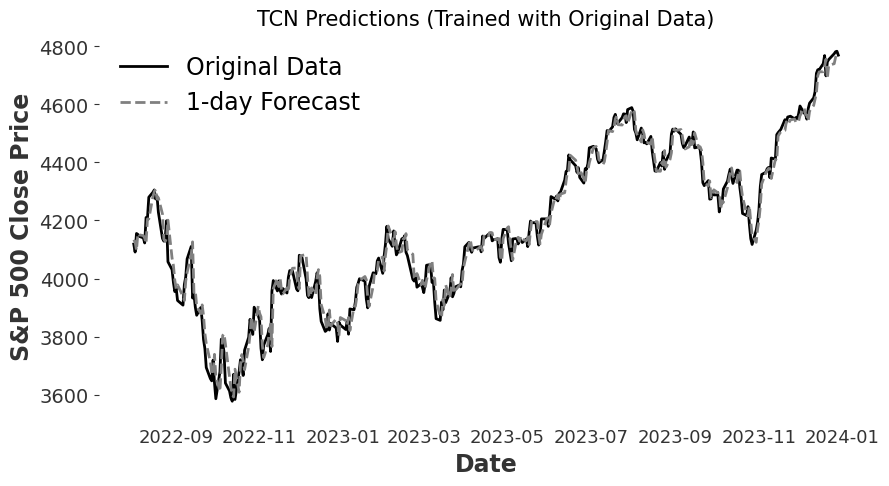

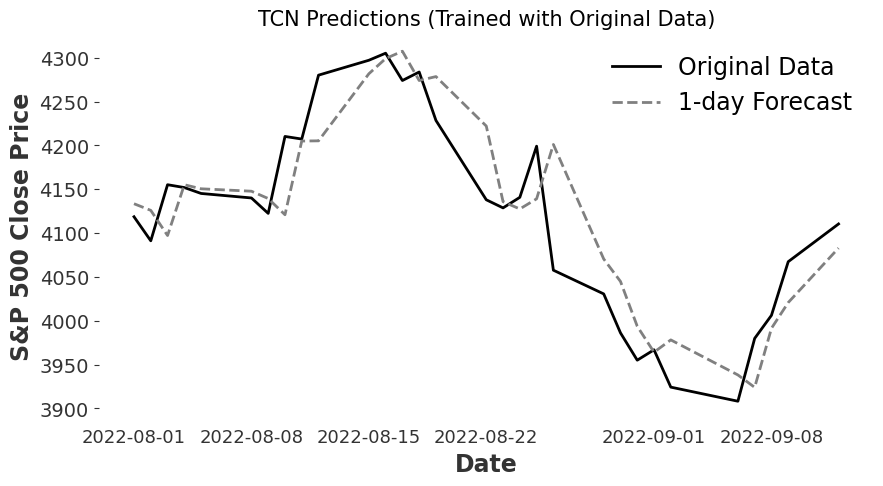


Directional Movement Metrics:

TCN (Original) | Train Accuracy: 47.08%
TCN (Original) | Validation Accuracy: 50.42%
TCN (Original) | Test Accuracy: 48.60%
TCN (Original) | Recall: 51.96%
TCN (Original) | Precision (Rise): 48.95%
TCN (Original) | Precision (Fall): 48.19%
TCN (Original) | F1 Score: 50.41%


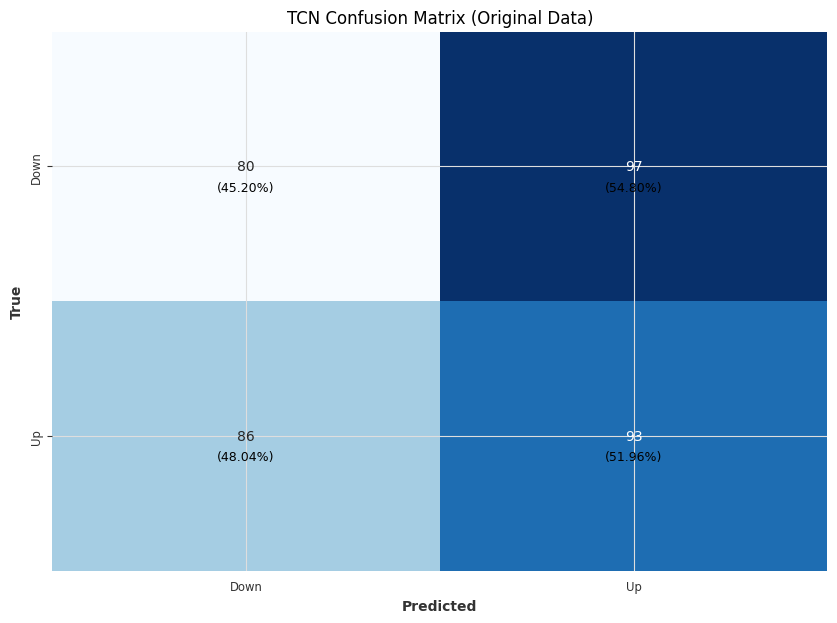

In [32]:
model = get_model_tcn()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.

Price Prediction Metrics:

TCN (Denoised) | MAE: 35.13
TCN (Denoised) | MSE: 1987.76
TCN (Denoised) | RMSE: 44.58
TCN (Denoised) | RMSSE: 1.04
TCN (Denoised) | MAPE: 0.86%
TCN (Denoised) | MASE: 1.08
TCN (Denoised) | R2: 0.97


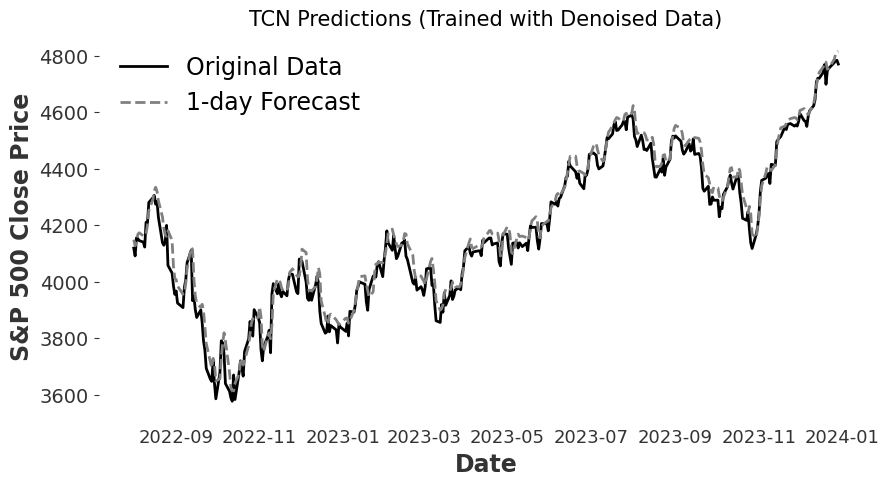

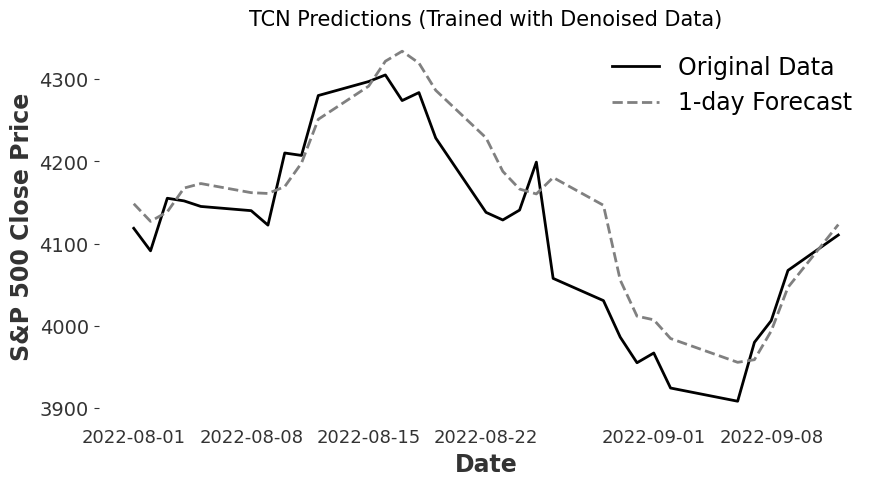


Directional Movement Metrics:

TCN (Denoised) | Train Accuracy: 64.73%
TCN (Denoised) | Validation Accuracy: 64.51%
TCN (Denoised) | Test Accuracy: 64.61%
TCN (Denoised) | Recall: 68.72%
TCN (Denoised) | Precision (Rise): 63.73%
TCN (Denoised) | Precision (Fall): 65.64%
TCN (Denoised) | F1 Score: 66.13%


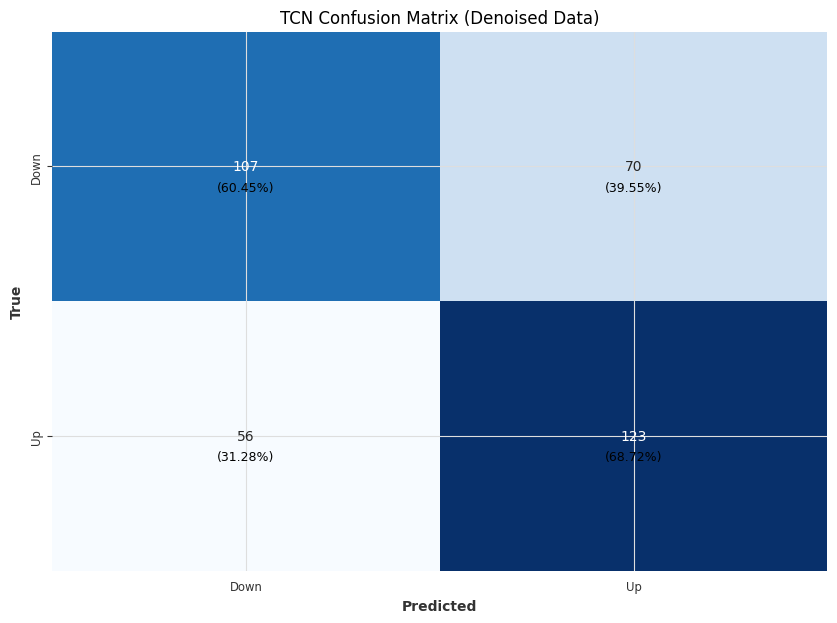

In [33]:
model = get_model_tcn()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pyt

Price Prediction Metrics:

DeepTCN (Original) | MAE: 41.67
DeepTCN (Original) | MSE: 2732.82
DeepTCN (Original) | RMSE: 52.28
DeepTCN (Original) | RMSSE: 1.22
DeepTCN (Original) | MAPE: 1.00%
DeepTCN (Original) | MASE: 1.28
DeepTCN (Original) | R2: 0.96


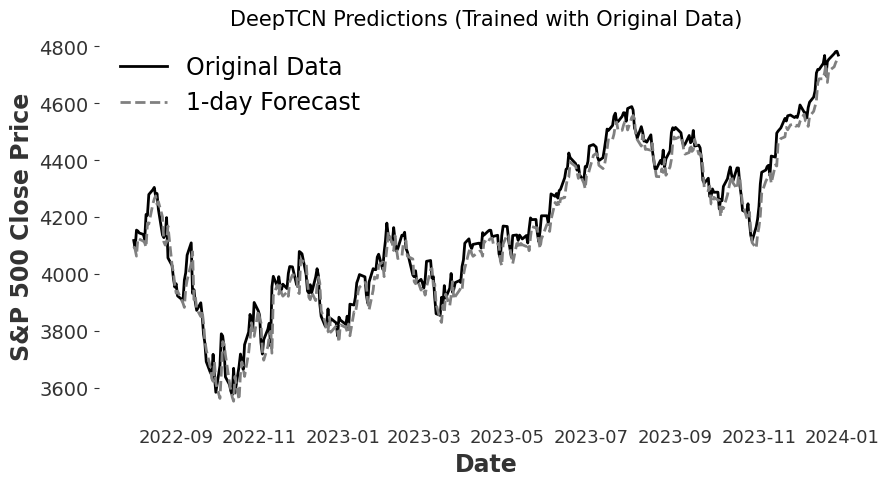

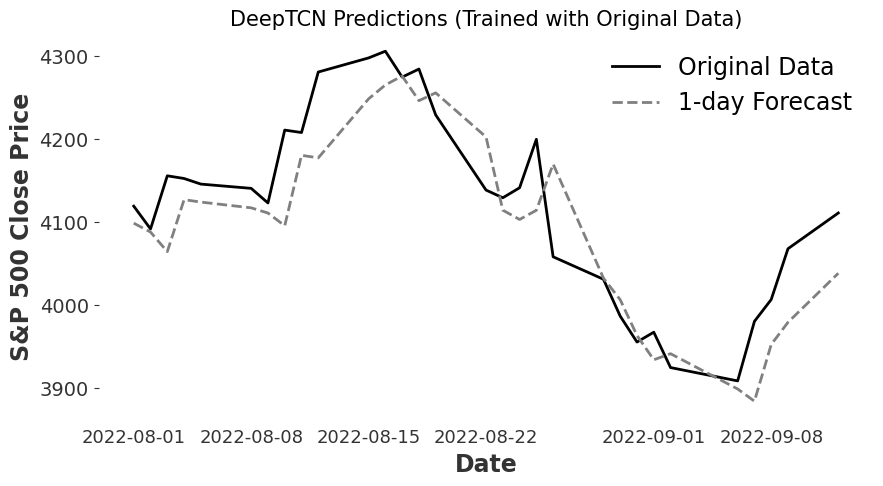


Directional Movement Metrics:

DeepTCN (Original) | Train Accuracy: 47.43%
DeepTCN (Original) | Validation Accuracy: 49.30%
DeepTCN (Original) | Test Accuracy: 48.60%
DeepTCN (Original) | Recall: 49.16%
DeepTCN (Original) | Precision (Rise): 48.89%
DeepTCN (Original) | Precision (Fall): 48.30%
DeepTCN (Original) | F1 Score: 49.03%


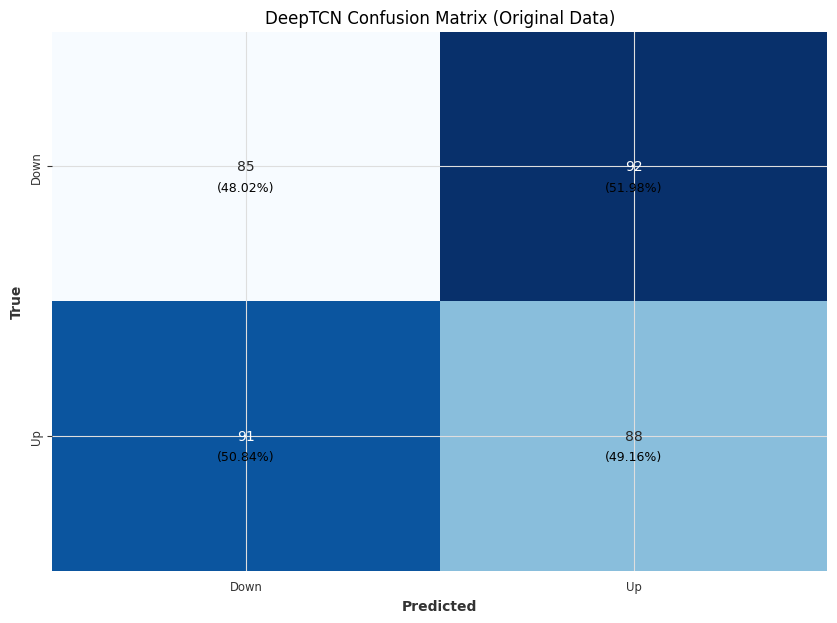

In [34]:
model = get_model_deeptcn()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pyt

Price Prediction Metrics:

DeepTCN (Denoised) | MAE: 36.85
DeepTCN (Denoised) | MSE: 2060.67
DeepTCN (Denoised) | RMSE: 45.39
DeepTCN (Denoised) | RMSSE: 1.06
DeepTCN (Denoised) | MAPE: 0.89%
DeepTCN (Denoised) | MASE: 1.13
DeepTCN (Denoised) | R2: 0.97


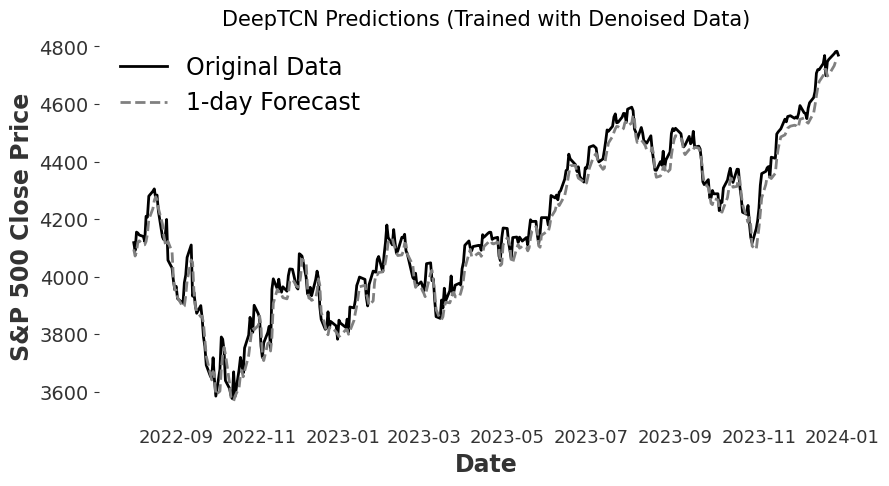

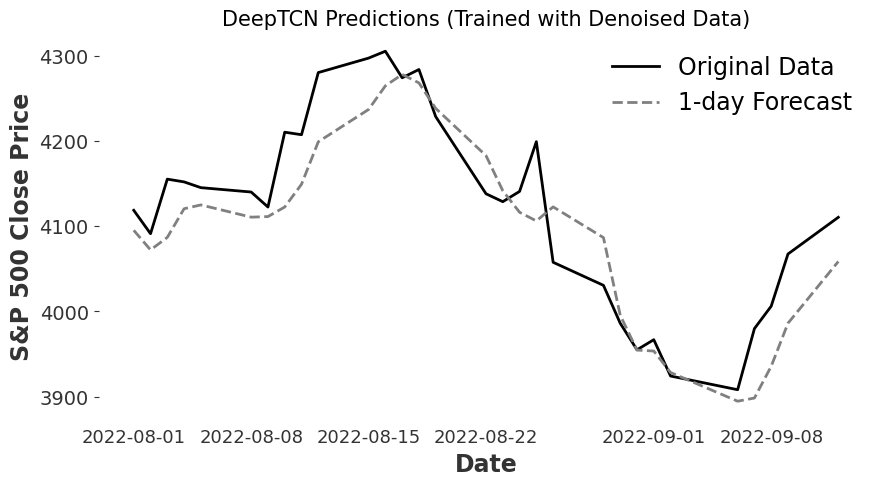


Directional Movement Metrics:

DeepTCN (Denoised) | Train Accuracy: 64.43%
DeepTCN (Denoised) | Validation Accuracy: 62.54%
DeepTCN (Denoised) | Test Accuracy: 63.20%
DeepTCN (Denoised) | Recall: 68.16%
DeepTCN (Denoised) | Precision (Rise): 62.24%
DeepTCN (Denoised) | Precision (Fall): 64.38%
DeepTCN (Denoised) | F1 Score: 65.07%


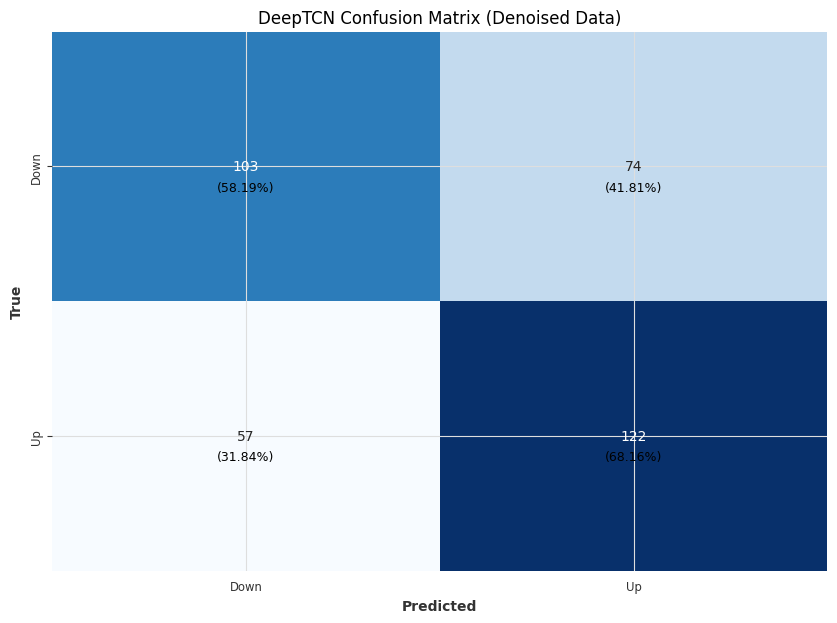

In [35]:
model = get_model_deeptcn()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:py

Price Prediction Metrics:

TiDE (Original) | MAE: 35.01
TiDE (Original) | MSE: 2059.77
TiDE (Original) | RMSE: 45.38
TiDE (Original) | RMSSE: 1.05
TiDE (Original) | MAPE: 0.86%
TiDE (Original) | MASE: 1.07
TiDE (Original) | R2: 0.97


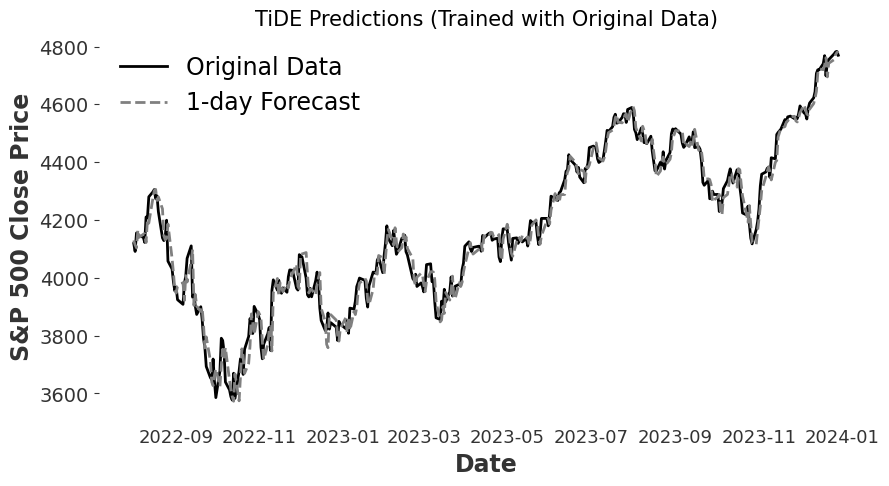

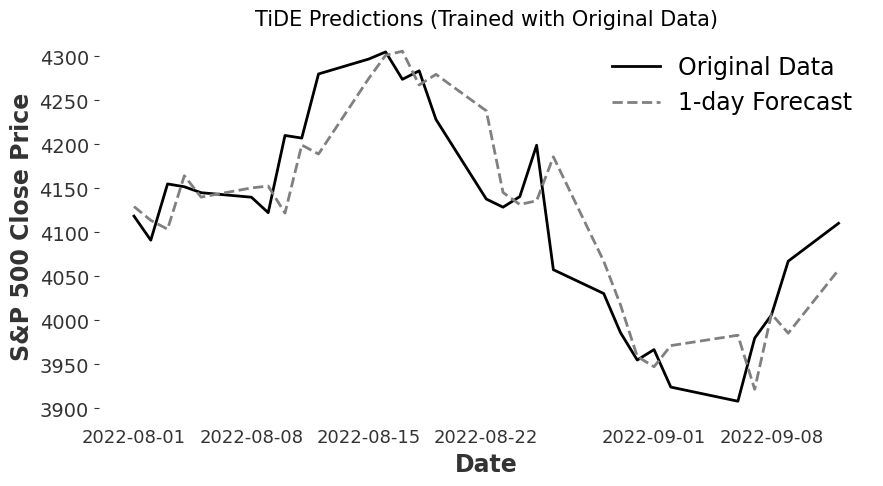


Directional Movement Metrics:

TiDE (Original) | Train Accuracy: 50.94%
TiDE (Original) | Validation Accuracy: 49.30%
TiDE (Original) | Test Accuracy: 51.97%
TiDE (Original) | Recall: 55.31%
TiDE (Original) | Precision (Rise): 52.11%
TiDE (Original) | Precision (Fall): 51.81%
TiDE (Original) | F1 Score: 53.66%


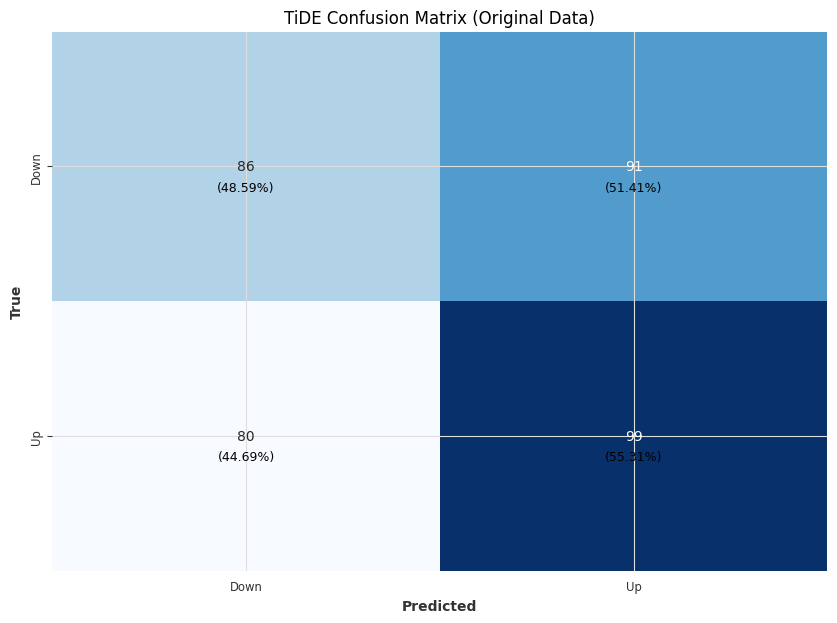

In [36]:
model = get_model_tide()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:py

Price Prediction Metrics:

TiDE (Denoised) | MAE: 21.49
TiDE (Denoised) | MSE: 764.69
TiDE (Denoised) | RMSE: 27.65
TiDE (Denoised) | RMSSE: 0.64
TiDE (Denoised) | MAPE: 0.52%
TiDE (Denoised) | MASE: 0.66
TiDE (Denoised) | R2: 0.99


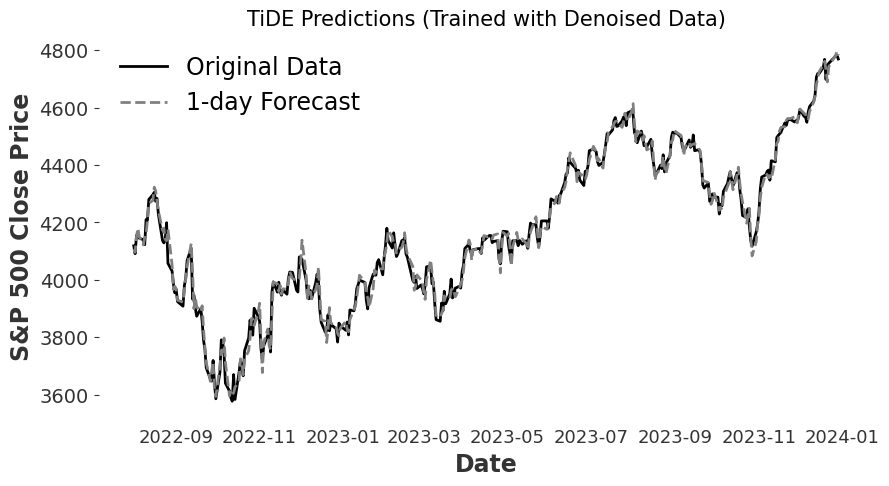

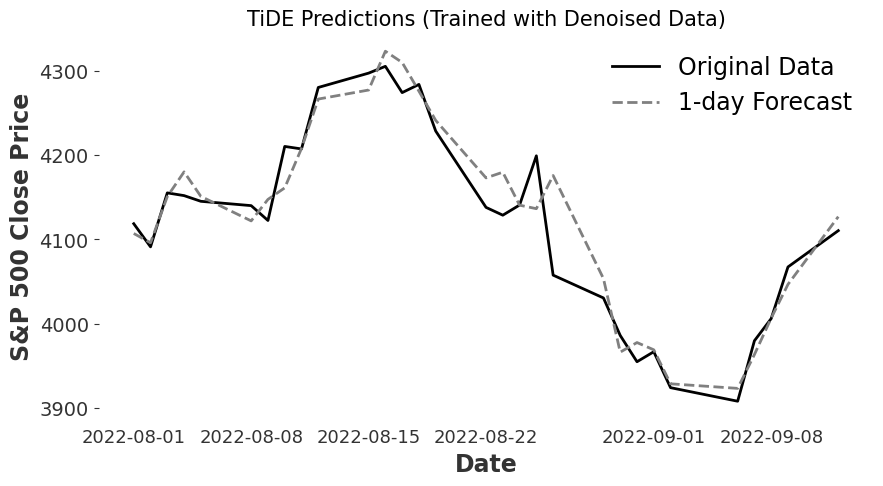


Directional Movement Metrics:

TiDE (Denoised) | Train Accuracy: 68.02%
TiDE (Denoised) | Validation Accuracy: 72.11%
TiDE (Denoised) | Test Accuracy: 69.38%
TiDE (Denoised) | Recall: 74.86%
TiDE (Denoised) | Precision (Rise): 67.68%
TiDE (Denoised) | Precision (Fall): 71.52%
TiDE (Denoised) | F1 Score: 71.09%


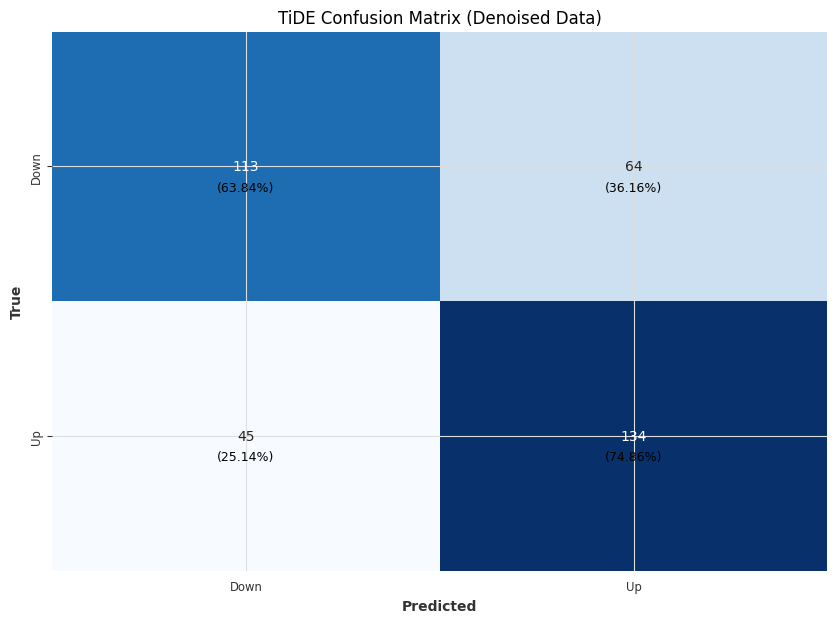

In [37]:
model = get_model_tide()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

In [38]:
import torch
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.utils.callbacks import TFMProgressBar

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | train_metrics | MetricCollection | 0      | train
1 | val_metrics   | MetricCollection | 0      | train
2 | rin           | RINorm           | 2      | train
3 | stacks        | ModuleList       | 861 K  | train
-----------------------------------------------------------
851 K     Trainable params
10.3 K    Non-trainable params
861 K     Total params
3.445     Total estimated model params size (MB)
40        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-HiTS (Original) | MAE: 46.28
N-HiTS (Original) | MSE: 4055.77
N-HiTS (Original) | RMSE: 63.68
N-HiTS (Original) | RMSSE: 1.48
N-HiTS (Original) | MAPE: 1.13%
N-HiTS (Original) | MASE: 1.42
N-HiTS (Original) | R2: 0.95


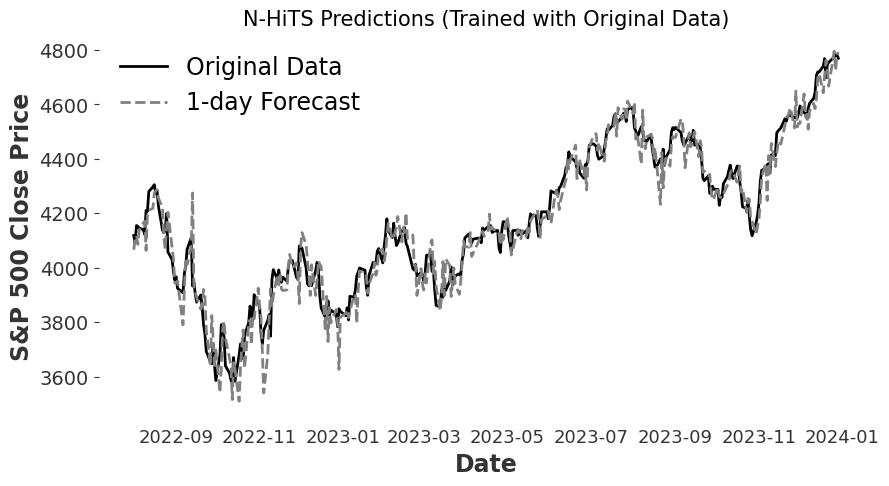

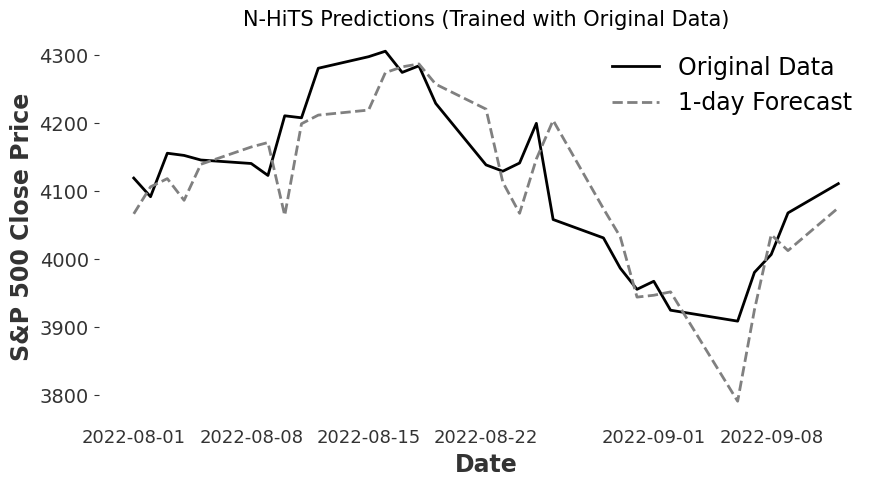


Directional Movement Metrics:

N-HiTS (Original) | Train Accuracy: 49.72%
N-HiTS (Original) | Validation Accuracy: 48.45%
N-HiTS (Original) | Test Accuracy: 54.49%
N-HiTS (Original) | Recall: 58.10%
N-HiTS (Original) | Precision (Rise): 54.45%
N-HiTS (Original) | Precision (Fall): 54.55%
N-HiTS (Original) | F1 Score: 56.22%


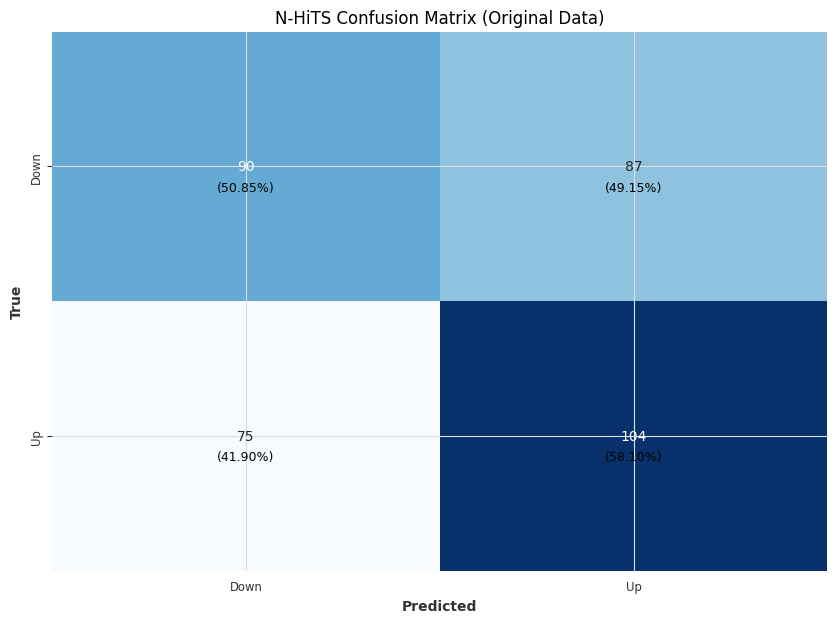

In [39]:
model = get_model_nhits()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | train_metrics | MetricCollection | 0      | train
1 | val_metrics   | MetricCollection | 0      | train
2 | rin           | RINorm           | 2      | train
3 | stacks        | ModuleList       | 861 K  | train
-----------------------------------------------------------
851 K     Trainable params
10.3 K    Non-trainable params
861 K     Total params
3.445     Total estimated model params size (MB)
40        Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-HiTS (Denoised) | MAE: 29.08
N-HiTS (Denoised) | MSE: 1406.95
N-HiTS (Denoised) | RMSE: 37.51
N-HiTS (Denoised) | RMSSE: 0.87
N-HiTS (Denoised) | MAPE: 0.71%
N-HiTS (Denoised) | MASE: 0.89
N-HiTS (Denoised) | R2: 0.98


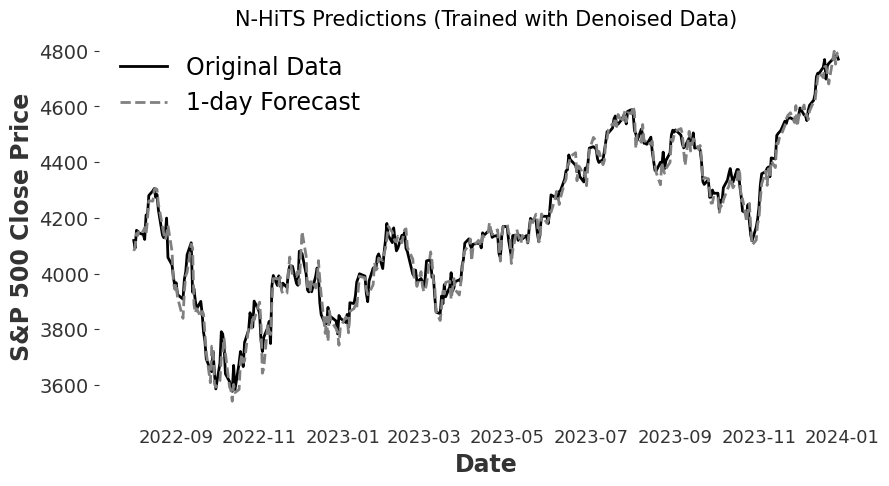

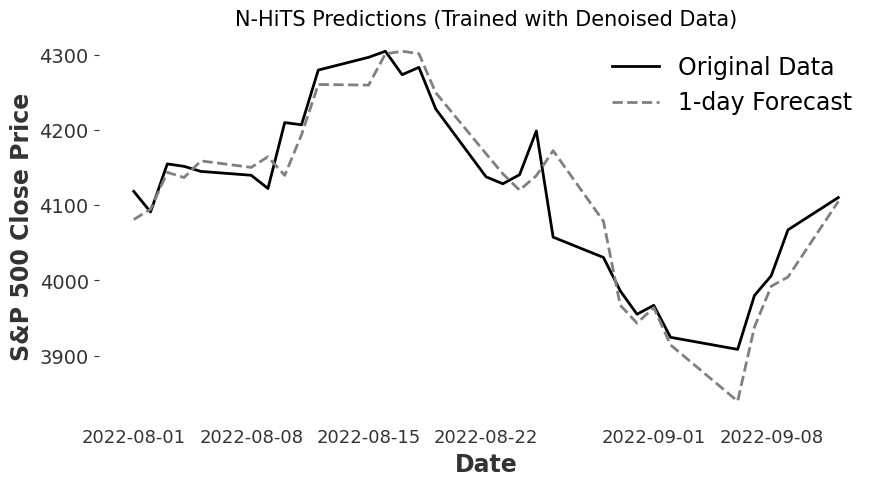


Directional Movement Metrics:

N-HiTS (Denoised) | Train Accuracy: 62.85%
N-HiTS (Denoised) | Validation Accuracy: 63.66%
N-HiTS (Denoised) | Test Accuracy: 66.85%
N-HiTS (Denoised) | Recall: 70.39%
N-HiTS (Denoised) | Precision (Rise): 65.97%
N-HiTS (Denoised) | Precision (Fall): 67.88%
N-HiTS (Denoised) | F1 Score: 68.11%


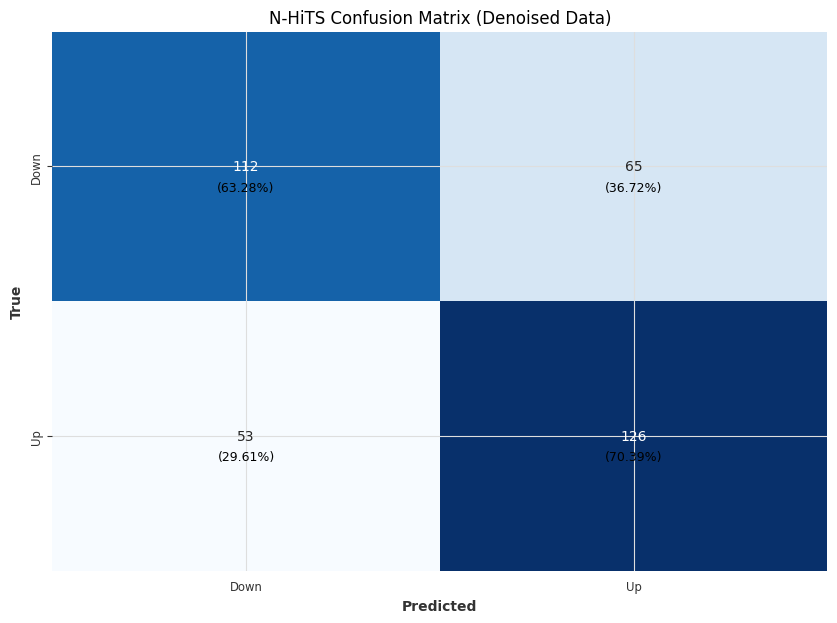

In [40]:
model = get_model_nhits()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | train_metrics         | MetricCollection | 0      | train
1 | val_metrics           | MetricCollection | 0      | train
2 | rin                   | RINorm           | 2      | train
3 | fc_hist               | Linear           | 21     | train
4 | feature_mixing_hist   | _FeatureMixing   | 5.3 K  | train
5 | feature_mixing_future | _FeatureMixing   | 5.2 K  | train
6 | conditional_mixer     | ModuleList       | 29.6 K | train
7 | fc_out                | Linear           | 1.1 K  | trai

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TSMixer (Original) | MAE: 45.83
TSMixer (Original) | MSE: 3945.49
TSMixer (Original) | RMSE: 62.81
TSMixer (Original) | RMSSE: 1.46
TSMixer (Original) | MAPE: 1.12%
TSMixer (Original) | MASE: 1.40
TSMixer (Original) | R2: 0.95


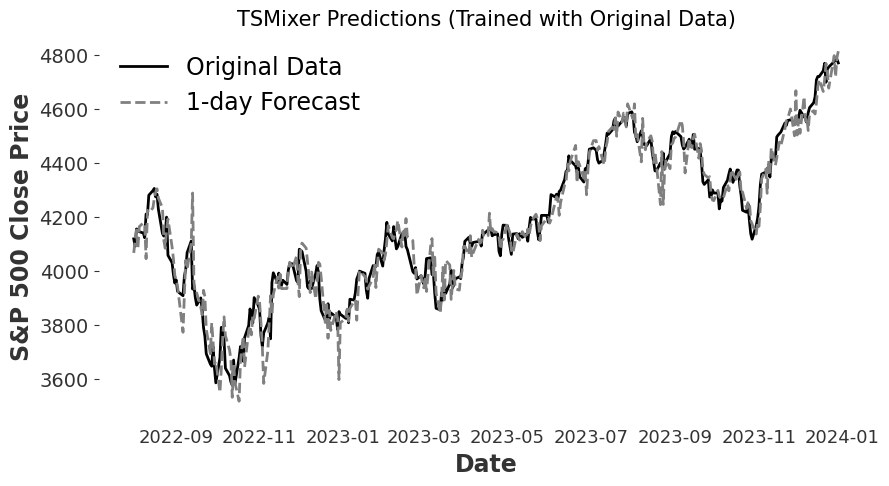

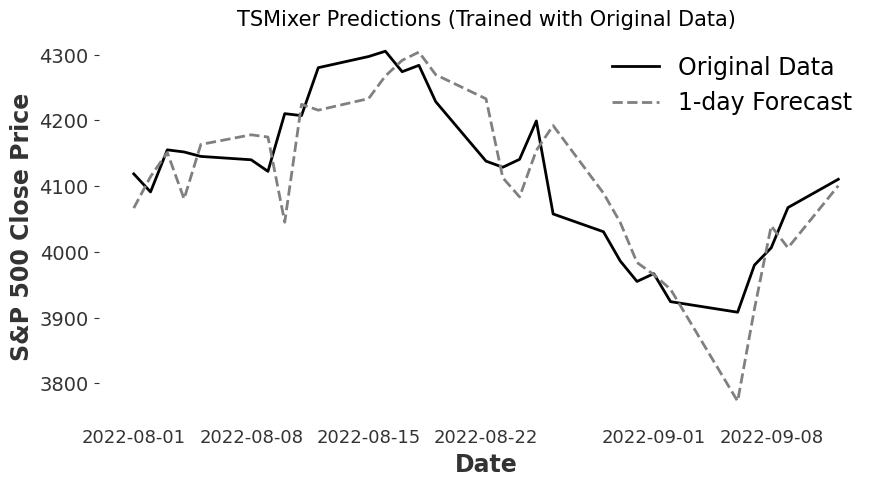


Directional Movement Metrics:

TSMixer (Original) | Train Accuracy: 49.25%
TSMixer (Original) | Validation Accuracy: 46.20%
TSMixer (Original) | Test Accuracy: 55.62%
TSMixer (Original) | Recall: 57.54%
TSMixer (Original) | Precision (Rise): 55.68%
TSMixer (Original) | Precision (Fall): 55.56%
TSMixer (Original) | F1 Score: 56.59%


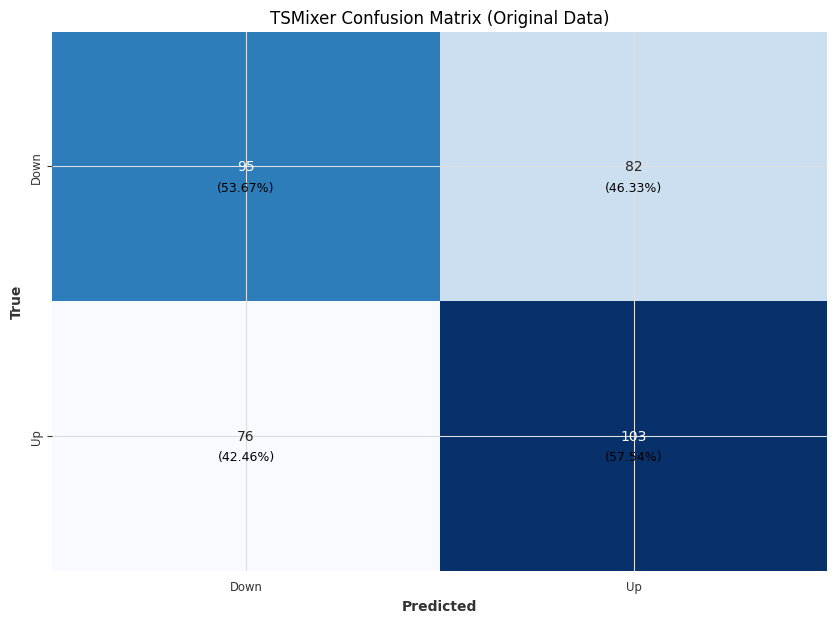

In [41]:
model = get_model_tsm()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params | Mode 
-------------------------------------------------------------------
0 | train_metrics         | MetricCollection | 0      | train
1 | val_metrics           | MetricCollection | 0      | train
2 | rin                   | RINorm           | 2      | train
3 | fc_hist               | Linear           | 21     | train
4 | feature_mixing_hist   | _FeatureMixing   | 5.3 K  | train
5 | feature_mixing_future | _FeatureMixing   | 5.2 K  | train
6 | conditional_mixer     | ModuleList       | 29.6 K | train
7 | fc_out                | Linear           | 1.1 K  | trai

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TSMixer (Denoised) | MAE: 31.35
TSMixer (Denoised) | MSE: 1844.45
TSMixer (Denoised) | RMSE: 42.95
TSMixer (Denoised) | RMSSE: 1.00
TSMixer (Denoised) | MAPE: 0.76%
TSMixer (Denoised) | MASE: 0.96
TSMixer (Denoised) | R2: 0.98


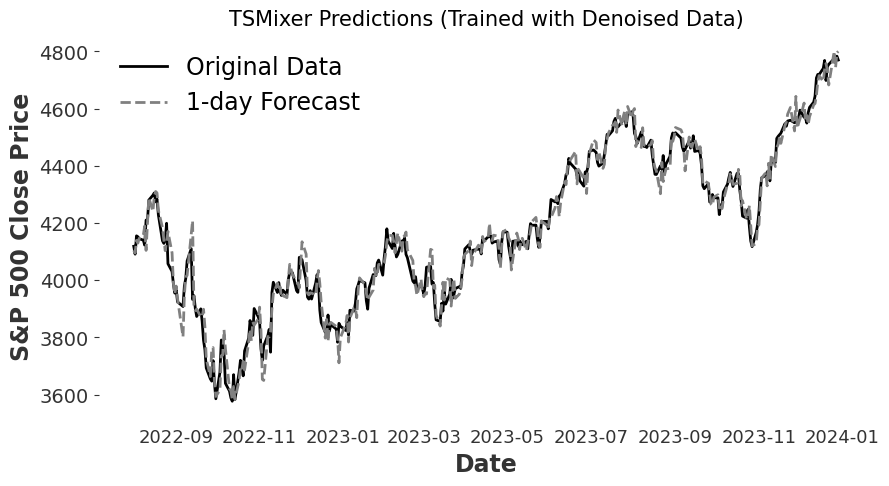

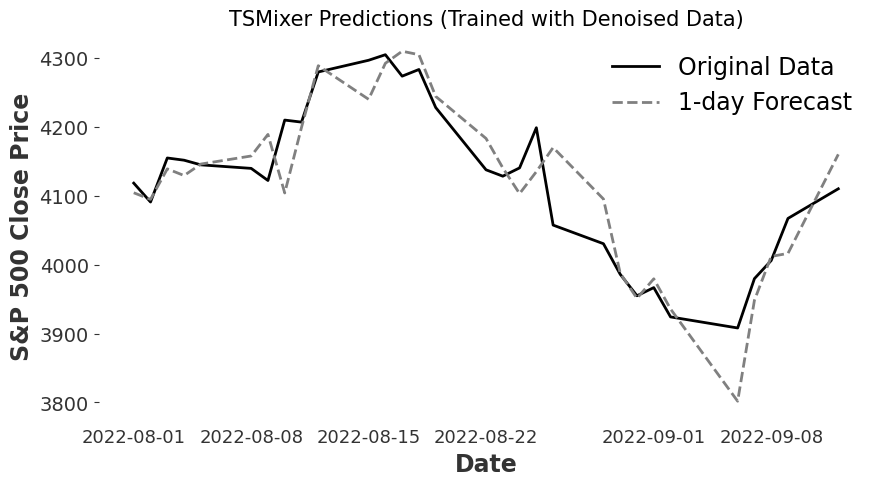


Directional Movement Metrics:

TSMixer (Denoised) | Train Accuracy: 60.86%
TSMixer (Denoised) | Validation Accuracy: 60.28%
TSMixer (Denoised) | Test Accuracy: 65.45%
TSMixer (Denoised) | Recall: 69.83%
TSMixer (Denoised) | Precision (Rise): 64.43%
TSMixer (Denoised) | Precision (Fall): 66.67%
TSMixer (Denoised) | F1 Score: 67.02%


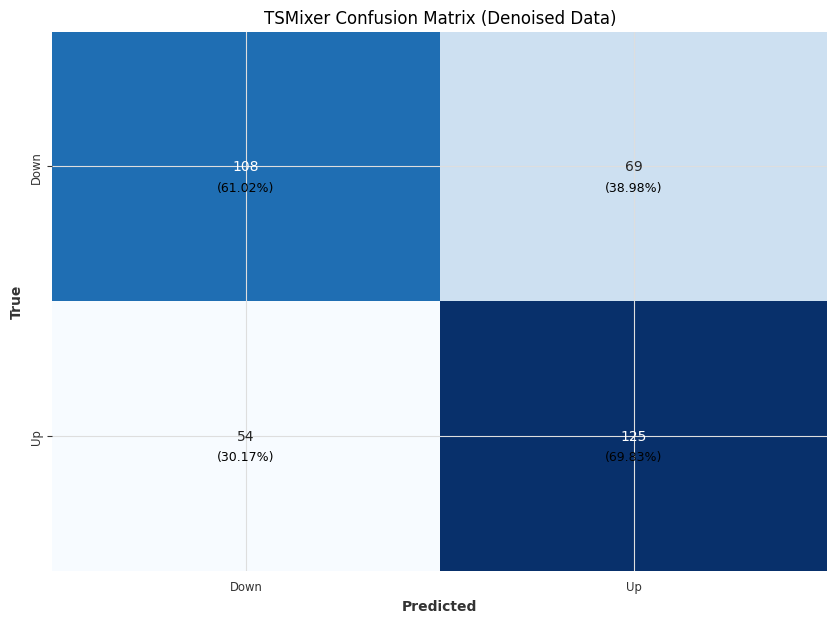

In [42]:
model = get_model_tsm()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | train_metrics | MetricCollection | 0      | train
1 | val_metrics   | MetricCollection | 0      | train
2 | rin           | RINorm           | 2      | train
3 | stacks        | ModuleList       | 8.5 M  | train
-----------------------------------------------------------
8.4 M     Trainable params
2.7 K     Non-trainable params
8.5 M     Total params
33.801    Total estimated model params size (MB)
134       Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-BEATS (Original) | MAE: 43.37
N-BEATS (Original) | MSE: 3387.58
N-BEATS (Original) | RMSE: 58.20
N-BEATS (Original) | RMSSE: 1.35
N-BEATS (Original) | MAPE: 1.06%
N-BEATS (Original) | MASE: 1.33
N-BEATS (Original) | R2: 0.95


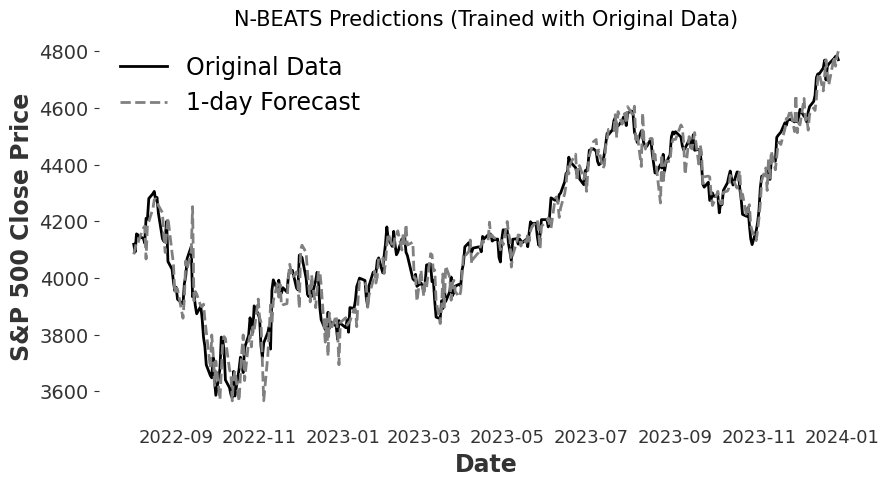

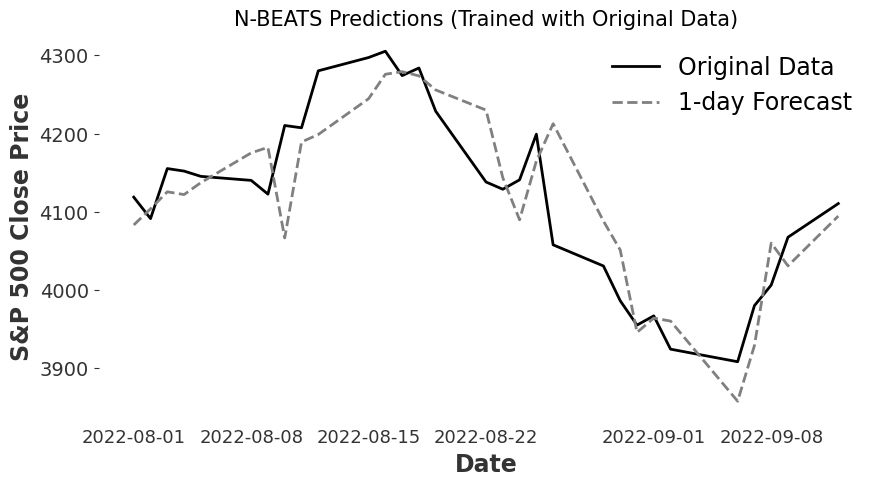


Directional Movement Metrics:

N-BEATS (Original) | Train Accuracy: 51.76%
N-BEATS (Original) | Validation Accuracy: 46.20%
N-BEATS (Original) | Test Accuracy: 54.49%
N-BEATS (Original) | Recall: 58.10%
N-BEATS (Original) | Precision (Rise): 54.45%
N-BEATS (Original) | Precision (Fall): 54.55%
N-BEATS (Original) | F1 Score: 56.22%


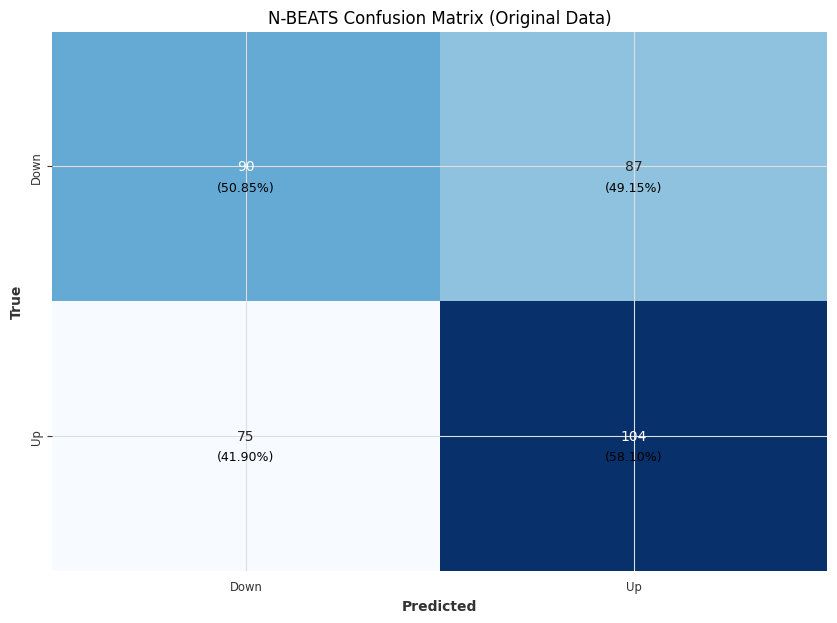

In [43]:
model = get_model_nbeats()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Original")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | train_metrics | MetricCollection | 0      | train
1 | val_metrics   | MetricCollection | 0      | train
2 | rin           | RINorm           | 2      | train
3 | stacks        | ModuleList       | 8.5 M  | train
-----------------------------------------------------------
8.4 M     Trainable params
2.7 K     Non-trainable params
8.5 M     Total params
33.801    Total estimated model params size (MB)
134       Modules in train mode
0         Modules in eval mode


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-BEATS (Denoised) | MAE: 19.82
N-BEATS (Denoised) | MSE: 698.12
N-BEATS (Denoised) | RMSE: 26.42
N-BEATS (Denoised) | RMSSE: 0.61
N-BEATS (Denoised) | MAPE: 0.48%
N-BEATS (Denoised) | MASE: 0.61
N-BEATS (Denoised) | R2: 0.99


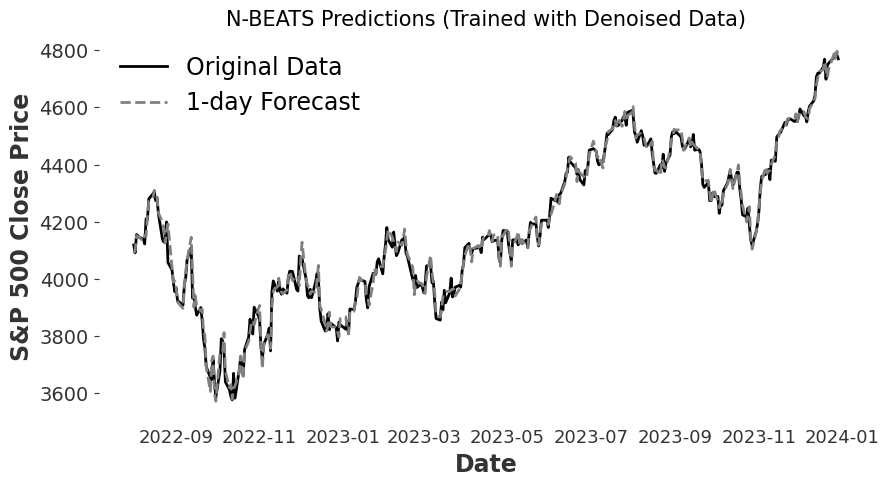

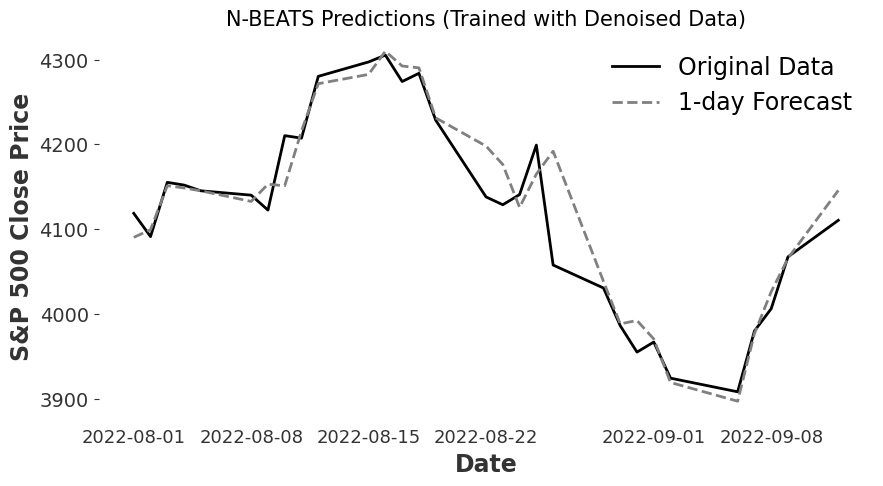


Directional Movement Metrics:

N-BEATS (Denoised) | Train Accuracy: 68.80%
N-BEATS (Denoised) | Validation Accuracy: 66.76%
N-BEATS (Denoised) | Test Accuracy: 70.51%
N-BEATS (Denoised) | Recall: 74.30%
N-BEATS (Denoised) | Precision (Rise): 69.27%
N-BEATS (Denoised) | Precision (Fall): 71.95%
N-BEATS (Denoised) | F1 Score: 71.70%


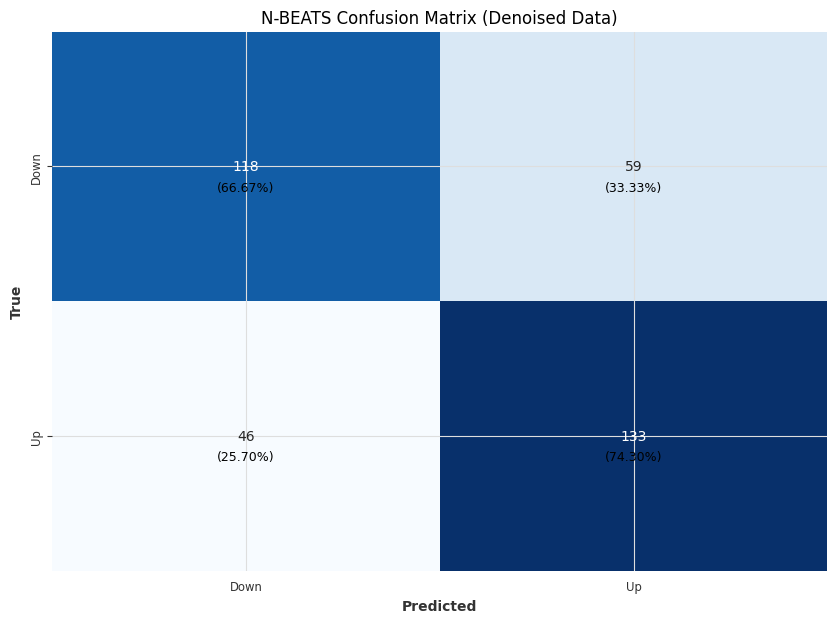

In [44]:
model = get_model_nbeats()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, STOCK, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)